In [218]:
import datetime
from dateutil.parser import parse
import itertools
from itertools import product
import math
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
import nolds
import numpy as np
import os
import pandas as pd
import pathlib
from PreprocessFcns import *
import pywt
import random
import scipy
from scipy.fftpack import fft
from scipy.signal import butter, welch, filtfilt, resample
from scipy.stats import skew, kurtosis, entropy, pearsonr
import seaborn as sns
import sklearn
from sklearn import multiclass
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
import time
%matplotlib inline

In [219]:
# set path to folder containing clinic watch data
path = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to destination folder
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [220]:
cf = RandomForestClassifier(n_estimators = 100)
le = sklearn.preprocessing.LabelEncoder()
grouper = LeaveOneGroupOut()

In [221]:
VisitNumber = {
    '2 Weeks: Time 0'   : 0,
    '2 Weeks: Time 30'  : 1,
    '2 Weeks: Time 60'  : 2,
    '2 Weeks: Time 90'  : 3,
    '2 Weeks: Time 120' : 4,
    '2 Weeks: Time 150' : 5,
    '1 Month'           : 6
}

ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

# Generate File Classifying Clips as Anomalies

In [222]:
def feature_extraction_anomaly(data_clip):
    
    # eliminate output of SettingwithCopyWarning
    pd.options.mode.chained_assignment = None
    
    features_list = ['RMSX', 'RMSY', 'RMSZ', 
                     'rangeX', 'rangeY', 'rangeZ', 
                     'meanX', 'meanY', 'meanZ', 
                     'varX', 'varY', 'varZ', 
                     'skewX', 'skewY', 'skewZ', 
                     'kurtX', 'kurtY', 'kurtZ', 
                     'xcorr_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ', 
                     'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 
                     'freq1', 'freq2', 'freq3', # added
                     'P1_rel', 'P2_rel', 'P3_rel', # added
                     'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 
                     'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur', 
                     'Sen_X', 'Sen_Y', 'Sen_Z', # not included in reduced features
                     'RMS_mag', 'range_mag', 'mean_mag', 'var_mag', 'skew_mag', 'kurt_mag', 'Sen_mag',  # not included
                     'Anomaly'] # added
    
    # raw axis data
    rawdata = data_clip
    
    # filtered axis data
    filtdata = filterdata(data_clip)
    
    # raw data with acc magnitude
    rawdata_wmag = rawdata.copy()
    rawdata_wmag['Accel_Mag'] = np.sqrt((rawdata**2).sum(axis = 1))
    
    # filtered data with acc magnitude - magnitude calculated prior to filtering
    filtdata_wmag = filterdata(rawdata_wmag)
    
    N = len(filtdata)
    min_xyz = np.min(filtdata, axis = 0)
    max_xyz = np.max(filtdata, axis = 0)
    xcorr_xy = np.correlate(filtdata.iloc[:, 0], filtdata.iloc[:, 1], mode = 'same')
    xcorr_xz = np.correlate(filtdata.iloc[:,0], filtdata.iloc[:, 2], mode = 'same')
    xcorr_yz = np.correlate(filtdata.iloc[:, 1], filtdata.iloc[:, 2], mode = 'same')
    Pxx = power_spectra_welch(rawdata_wmag, fm = 0, fM = 10) # generated using raw acceleration data (including magnitude)
    sH_raw = []; sH_fft = []

    
    # RMSX, RMSY, RMSZ
    # root mean square
    RMS = 1 / N * np.sqrt(np.asarray(np.sum(filtdata**2, axis = 0)))
    
    # rangeX, rangeY, rangeZ
    # range
    r = np.asarray(max_xyz - min_xyz)
    
    # meanX, meanY, meanZ
    # average
    mean = np.asarray(np.mean(filtdata, axis = 0))

    # varX, varY, varZ
    # standard deviation
    var = np.asarray(np.std(filtdata, axis = 0))

    # skewX, skewY, skewZ
    # skewness: measure of data symmetry
    sk = skew(filtdata)
    
    # kurtX, kurtY, kurtZ
    # kurtosis: measure of data tail weight compared to normal dist
    kurt = kurtosis(filtdata)

    # xcorr_peakXY, xcorr_peakXZ, xcorr_peakYZ
    # max correlation between data of paired axes
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_peak = np.array([xcorr_peak_xy, xcorr_peak_xz, xcorr_peak_yz])

    # xcorr_lagXY, xcorr_lagXZ, xcorr_lagYZ
    # relative location of max correlation between data of paired axes
    xcorr_lag_xy = (np.argmax(xcorr_xy)) / len(xcorr_xy)
    xcorr_lag_xz = (np.argmax(xcorr_xz)) / len(xcorr_xz)
    xcorr_lag_yz = (np.argmax(xcorr_yz)) / len(xcorr_yz)
    xcorr_lag = np.array([xcorr_lag_xy, xcorr_lag_xz, xcorr_lag_yz])

    # freq1, freq2, freq3
    # frequency with the highest power density
    freq1 = Pxx.iloc[:, -1].index[-1]
    freq2 = Pxx.iloc[:, -1].index[-2]
    freq3 = Pxx.iloc[:, -1].index[-3]
    domfreq = np.array([freq1, freq2, freq3])

    # P1_rel, P2_rel, P3_rel
    # relative power of the dominant frequency within the signal
    P1_rel = Pxx.loc[freq1].values / Pxx.iloc[:, -1].sum()
    P2_rel = Pxx.loc[freq2].values / Pxx.iloc[:, -1].sum()
    P3_rel = Pxx.loc[freq3].values / Pxx.iloc[:, -1].sum()
    Pdom_rel = np.concatenate((P1_rel, P2_rel, P3_rel))

    # PDS_mean, PDS_std, PDS_skew, PDS_kur
    # power spectral density summary stats
    Pxx_moments = np.array([np.nanmean(Pxx.values), np.nanstd(Pxx.values), skew(Pxx.values), kurtosis(Pxx.values)])

    # jerk_mean, jerk_std, jerk_skew, jerk_kur
    jerk = filtdata_wmag['Accel_Mag'].diff().values
    jerk_moments = np.array([np.nanmean(jerk), np.nanstd(jerk), 
                             skew(jerk[~np.isnan(jerk)]), kurtosis(jerk[~np.isnan(jerk)])])

    # Sen_X, Sen_Y, Sen_Z
    # sample entropy
    for a in range(3):
        x = filtdata.iloc[:, a]
        n = len(x)
        Fs = np.mean(1 / (np.diff(x.index) / 1000))
        sH_raw.append(nolds.sampen(x))
    
    # features of the acceleration magnitude (as opposed to the axis values)
    RMS_mag = 1 / N * np.sqrt(np.sum(filtdata_wmag['Accel_Mag']**2, axis = 0))
    r_mag = np.max(filtdata_wmag['Accel_Mag']) - np.min(filtdata_wmag['Accel_Mag'])
    mean_mag = np.mean(filtdata_wmag['Accel_Mag'])
    var_mag = np.std(filtdata_wmag['Accel_Mag'])
    sk_mag = skew(filtdata_wmag['Accel_Mag'])
    kurt_mag = kurtosis(filtdata_wmag['Accel_Mag'])
    sH_mag = nolds.sampen(filtdata_wmag['Accel_Mag'])
    
    # boolean feature describing whether sitting/standing clip has anomylous movement
    # range between 0.1 and 99.9 percentile of agreeing 'tremorless' scores from FFT scoring
    NormRange = 0.08082132917876517
    if (np.max(rawdata_wmag['Accel_Mag']) - np.min(rawdata_wmag['Accel_Mag'])) > NormRange:
        anomaly = 1
    else:
        anomaly = 0
    
    Y = np.array([RMS_mag, r_mag, mean_mag, var_mag, sk_mag, kurt_mag, sH_mag, anomaly])
    X = np.concatenate((RMS, r, mean, var, sk, kurt, xcorr_peak, xcorr_lag, 
                        domfreq, Pdom_rel, Pxx_moments, jerk_moments, sH_raw, Y))
    
    return X

In [261]:
# uses full list of features and three dominant frequencies as opposed to one
# overlapping data windows
# generates file for each window of data
def DataAggregator_Anomaly(file, data_type):
    '''generates feature metrics for 5-second intervals of apple watch data 
       50% overlap between data intervals - data windows saved to individual files
       utilizes additional features not present in previous DataAggregator
       data_type: \'clinic\' or \'home\'
       file: clinic data in the form (SubjID)_(VisitNum)_(TaskAbb); home data as full record file path'''
    
    TaskFeatures = pd.DataFrame()
    
    if data_type == 'clinic':
        subject = file[:4]
        visit = file[5:6]
        task = file[7:]
    if data_type == 'home':
        designation = file[63:-4]
    print(file)
    
    features_list = ['RMSX', 'RMSY', 'RMSZ', 
                     'rangeX', 'rangeY', 'rangeZ', 
                     'meanX', 'meanY', 'meanZ', 
                     'varX', 'varY', 'varZ', 
                     'skewX', 'skewY', 'skewZ', 
                     'kurtX', 'kurtY', 'kurtZ', 
                     'xcorr_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ', 
                     'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 
                     'freq1', 'freq2', 'freq3', # added
                     'P1_rel', 'P2_rel', 'P3_rel', # added
                     'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 
                     'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur', 
                     'Sen_X', 'Sen_Y', 'Sen_Z', # not included in reduced features
                     'RMS_mag', 'range_mag', 'mean_mag', 'var_mag', 'skew_mag', 'kurt_mag', 'Sen_mag',  # not included
                     'Anomaly'] # added
        
    # get acc data
    try:
        if data_type == 'clinic':
            data = (pd.read_csv(os.path.join(path, 'TaskAcc', file + '.csv'), parse_dates = ['timestamp'])
                    [['timestamp', 'x', 'y', 'z']])
            data.columns = ['Timestamp', 'X', 'Y', 'Z']
        if data_type == 'home':
            data = pd.read_csv(file, parse_dates = ['Timestamp'])[['Timestamp', 'X', 'Y', 'Z']]
    except(FileNotFoundError):
        if data_type == 'clinic':
            print('No data found for subject %s %s visit %s' % (subject, task, visit))
        if data_type == 'home':
            print('No data found for %s' % (designation))
        return TaskFeatures
        
    # organize data and make 5 second clips
    data = data.sort_values(by = 'Timestamp', axis = 0)
    data['TimeWdw'] = [(tm - datetime.timedelta(minutes = 0,
                                                    seconds = tm.second % 2.5,
                                                    microseconds = tm.microsecond)) 
                          for tm in data.Timestamp]
    data['TimeIdx'] = (data.Timestamp.values - data.Timestamp.values[0]).astype('timedelta64[ms]').astype(int)
    data = data.set_index('TimeIdx')

    # "clip" the data into 5 second chunks    
    five_sec_intervals = data.TimeWdw.unique()

    # calculate features
    F = []
    for t in five_sec_intervals:
        clip = data.loc[(data.TimeWdw == t) | (data.TimeWdw == (t + np.timedelta64(2500, 'ms')))]
        # length of 5 second chunk should be 250 for 5 seconds
        if (clip.empty or (len(clip.TimeWdw) < 200)):
            continue
        else:
            F.append(feature_extraction_anomaly(clip[['X', 'Y', 'Z']]))

    # create features dataframe
    TaskFeatures = pd.DataFrame(data = F, columns = features_list, dtype = 'float32')    
    
    return TaskFeatures

In [262]:
### GENERATING FEATURES FROM CLINIC DATA USING EXPANDED FEATURES LIST AND OVERLAPPING WINDOWS
# RELATED FILE NAMED ClinicDataFeaturesX
# ADDS COLUMN OF WINDOW NUMBER
s_time = time.time()

clinicData = pd.read_csv(os.path.join(path, 'Metadata Tables', 'Table4.csv'))
clinicData = clinicData[(clinicData.TaskAbb == 'Sitng') | (clinicData.TaskAbb == 'Stndg')]

DataFeatures = pd.DataFrame()
for task in clinicData.iterrows():
    file = str(int(task[1]['SubjID'])) + '_' + str(VisitNumber[task[1]['Visit']]) + '_' + task[1]['TaskAbb']
    TaskFeatures = DataAggregator_Anomaly(file, 'clinic')
    if TaskFeatures.empty:
        continue
    featcols = list(TaskFeatures.columns)
    
    TaskFeatures['SubjID'] = int(task[1]['SubjID'])
    TaskFeatures['Visit'] = VisitNumber[task[1]['Visit']]
    TaskFeatures['TaskAbb'] = task[1]['TaskAbb']
    TaskFeatures['Clip'] = range(len(TaskFeatures))
    TaskFeatures['Tremor'] = task[1]['Tremor - ' + task[1]['Side']]
    
    cols = ['SubjID', 'Visit', 'TaskAbb', 'Clip', 'Tremor'] + featcols
    TaskFeatures = TaskFeatures[cols]
    
    if DataFeatures.empty:
        DataFeatures = TaskFeatures
        continue
    DataFeatures = pd.concat([DataFeatures, TaskFeatures], ignore_index = True)

DataFeatures.to_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'), index = False)

print(str(int(((time.time() - s_time) / 60) / 60)) + ' hours ' + 
      str(int(((time.time() - s_time) / 60) % 60)) + ' minutes ' + 
      str(int((time.time() - s_time) % 60)) + ' seconds')

1003_0_Sitng
1003_0_Stndg
1003_1_Sitng
1003_1_Stndg
1003_2_Sitng
1003_2_Stndg
1003_3_Sitng
1003_3_Stndg
1003_4_Sitng
1003_4_Stndg
1003_5_Sitng
1003_5_Stndg
1003_6_Sitng
No data found for subject 1003 Sitng visit 6
1003_6_Stndg
No data found for subject 1003 Stndg visit 6
1004_0_Sitng
1004_0_Stndg
1004_1_Sitng
1004_1_Stndg
1004_2_Sitng
1004_2_Stndg
1004_3_Sitng
1004_3_Stndg
1004_4_Sitng
1004_4_Stndg
1004_5_Sitng
No data found for subject 1004 Sitng visit 5
1004_5_Stndg
No data found for subject 1004 Stndg visit 5
1004_6_Sitng
1004_6_Stndg
1005_0_Sitng
1005_0_Stndg
No data found for subject 1005 Stndg visit 0
1005_1_Sitng
1005_1_Stndg
1005_2_Sitng
1005_2_Stndg
1005_3_Sitng
1005_3_Stndg
1005_4_Sitng
No data found for subject 1005 Sitng visit 4
1005_4_Stndg
No data found for subject 1005 Stndg visit 4
1005_5_Sitng
No data found for subject 1005 Sitng visit 5
1005_5_Stndg
No data found for subject 1005 Stndg visit 5
1005_6_Sitng
No data found for subject 1005 Sitng visit 6
1005_6_Stndg
No d

0 hours 2 minutes 2 seconds


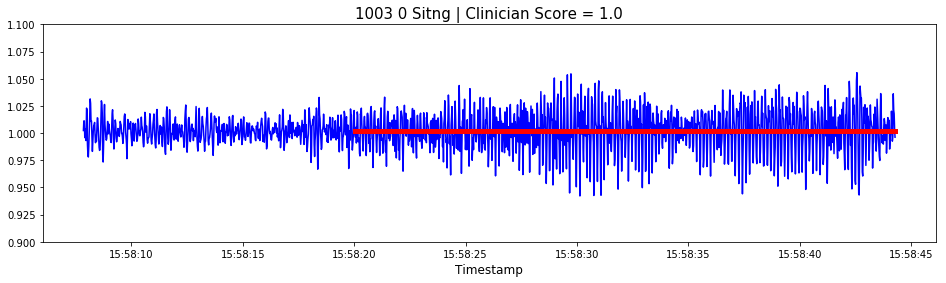

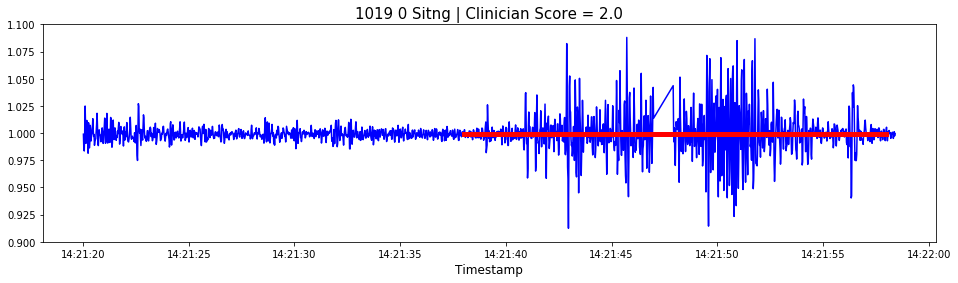

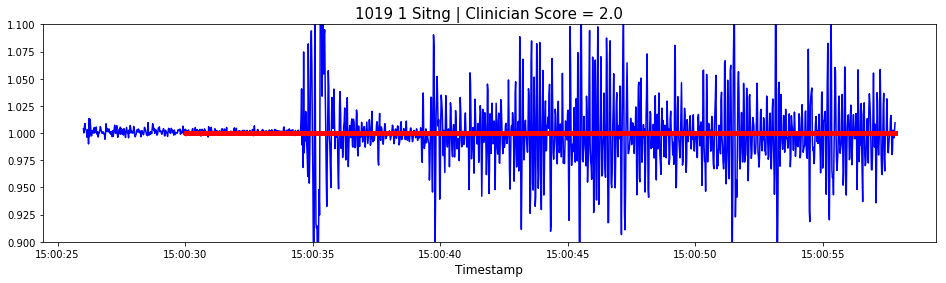

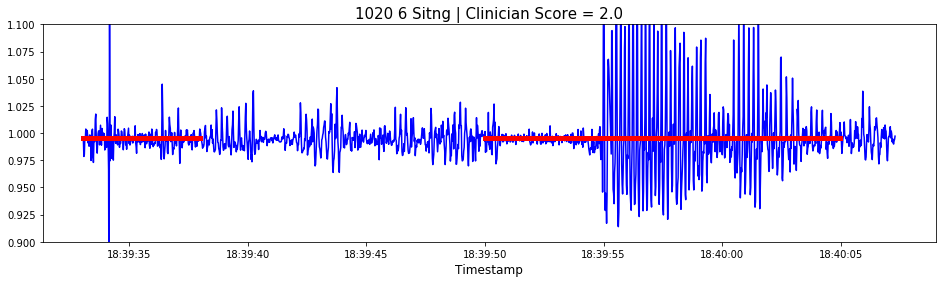

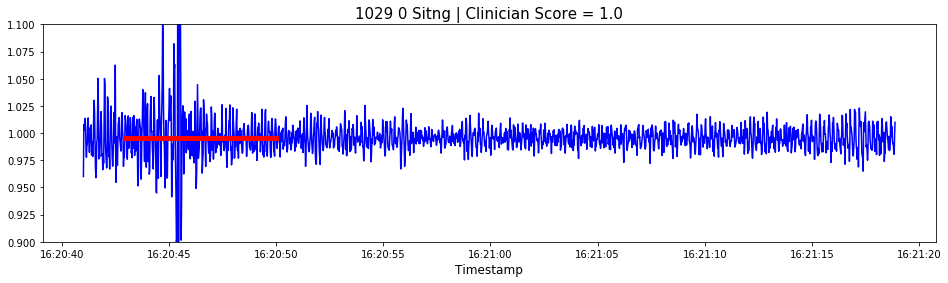

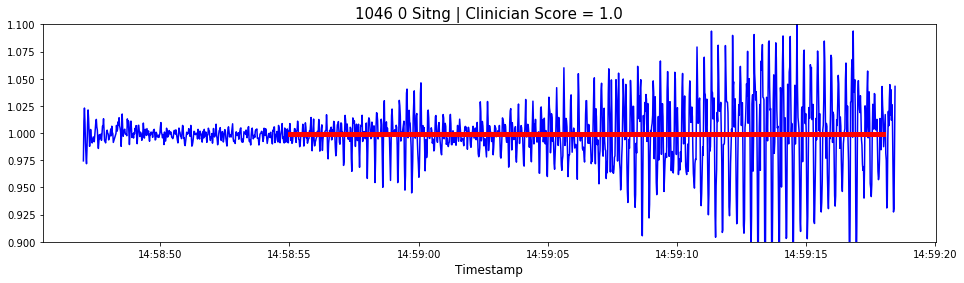

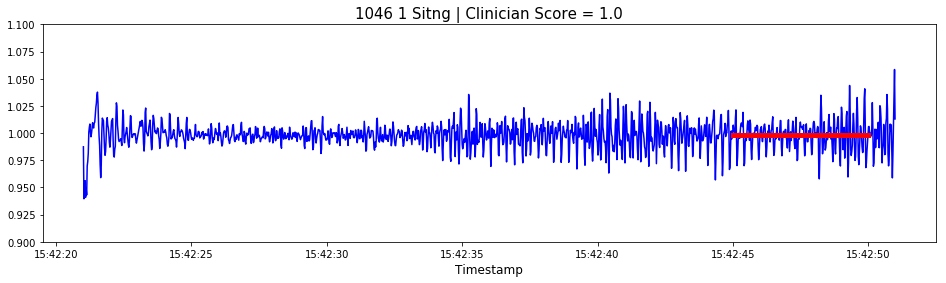

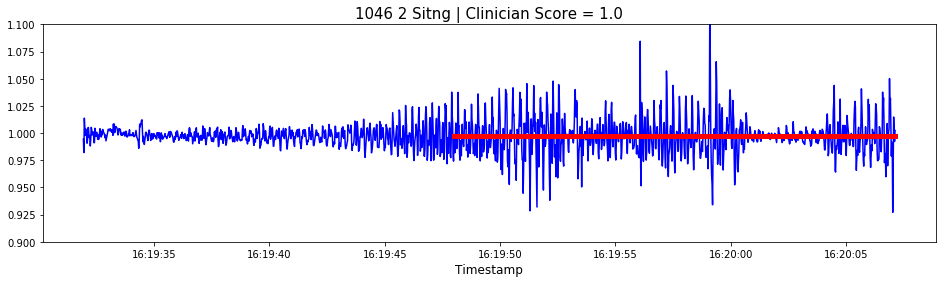

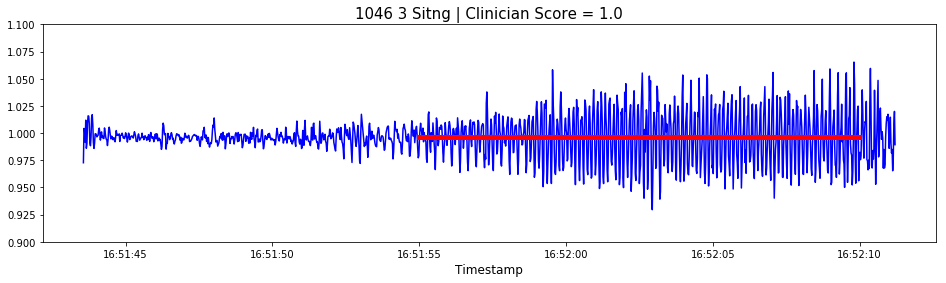

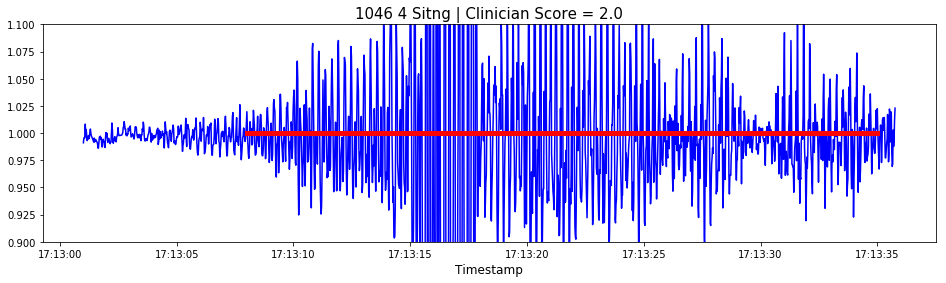

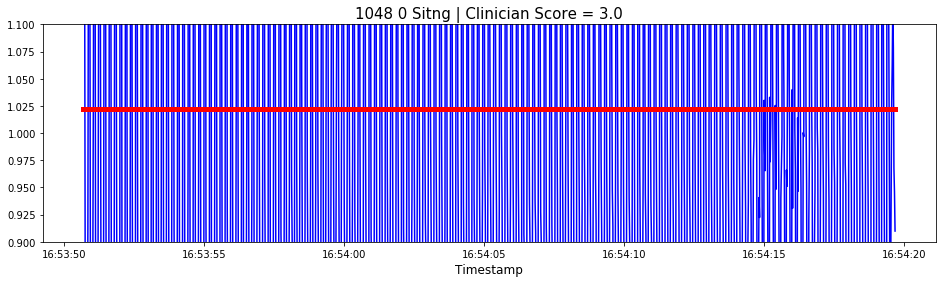

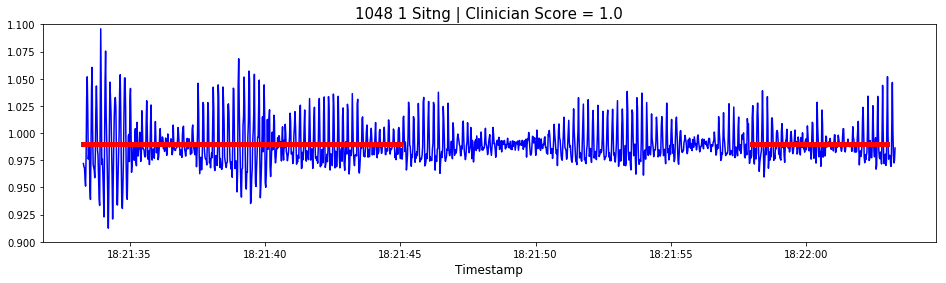

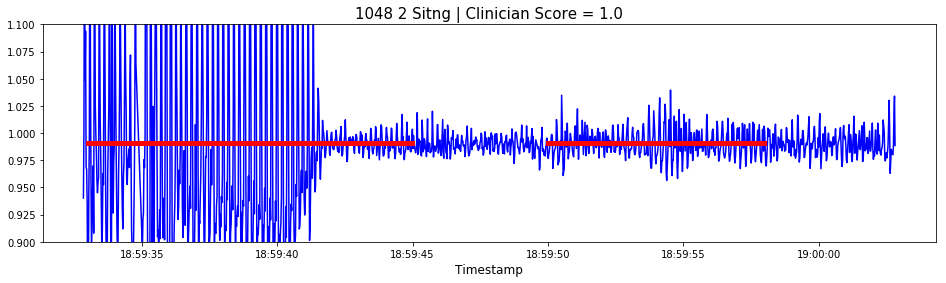

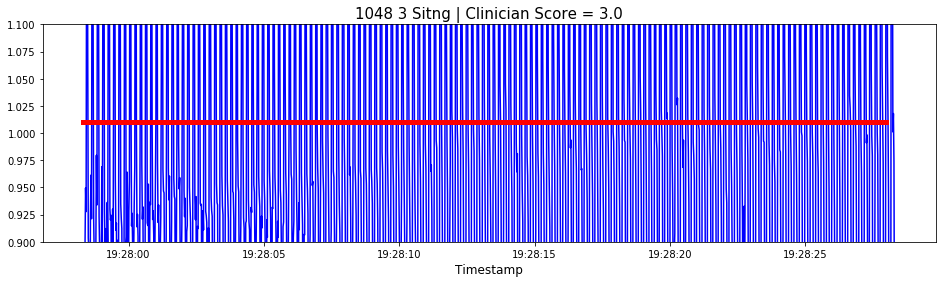

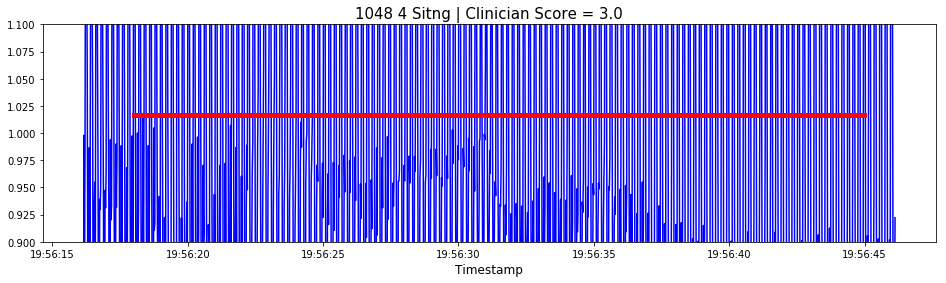

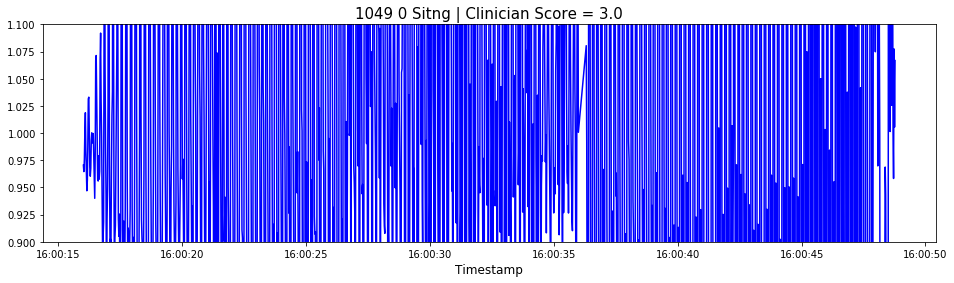

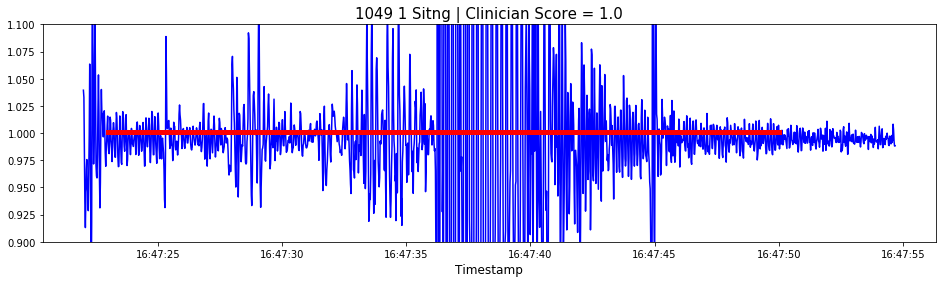

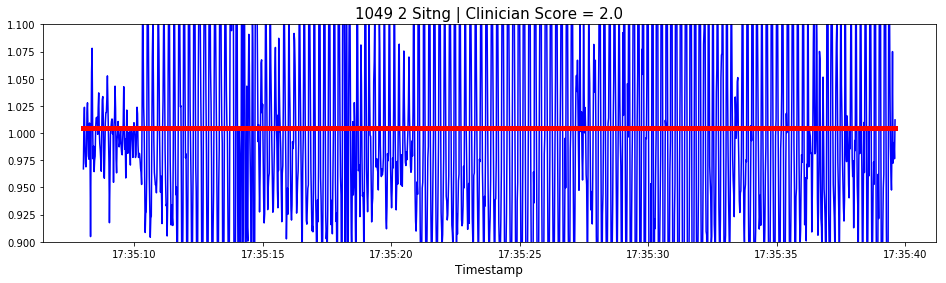

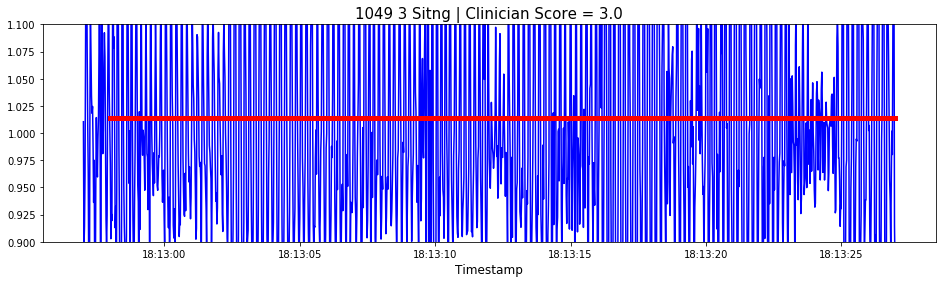

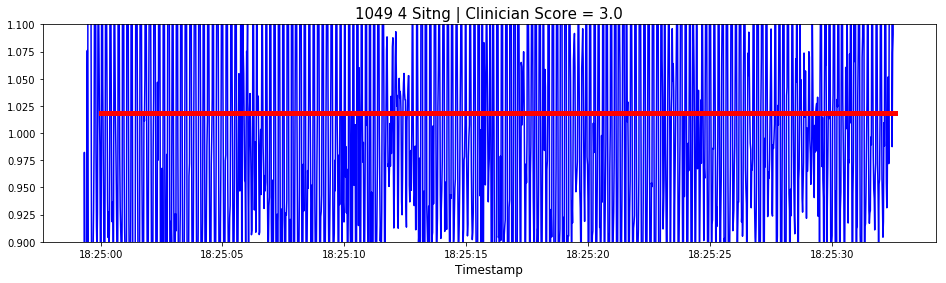

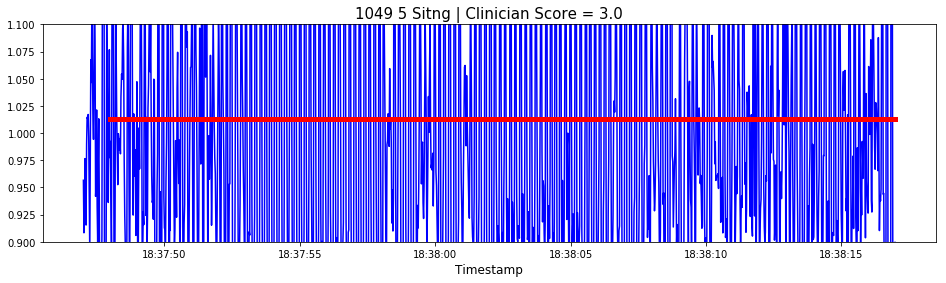

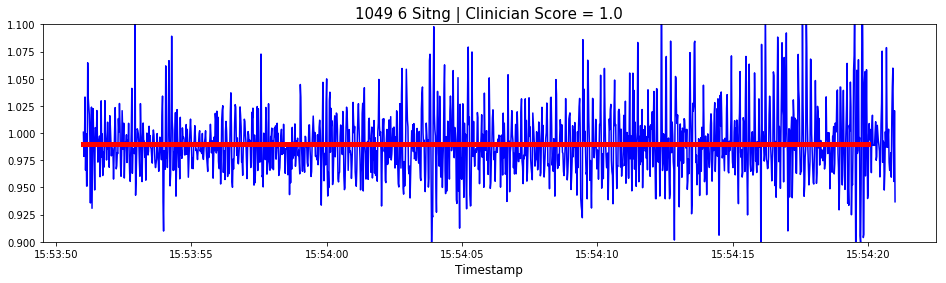

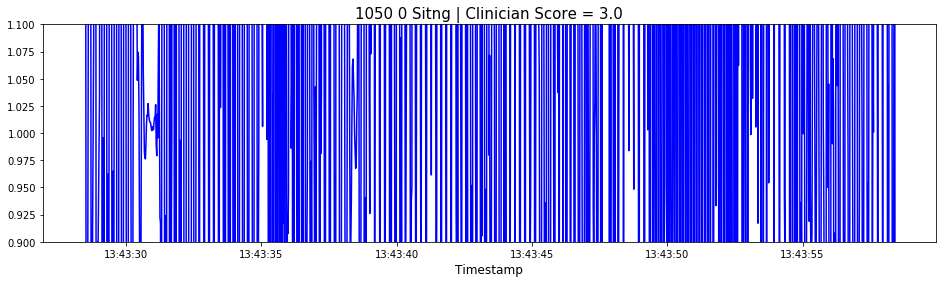

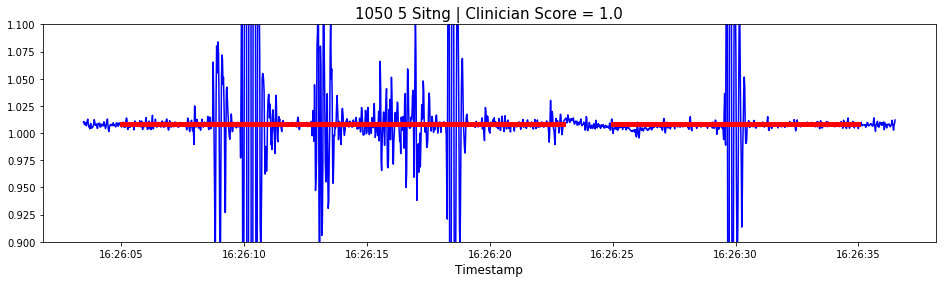

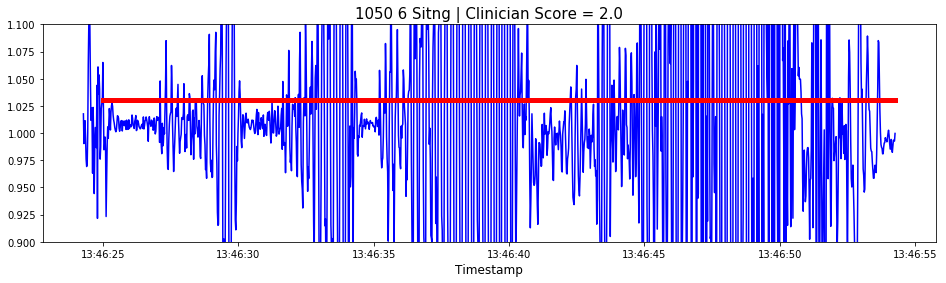

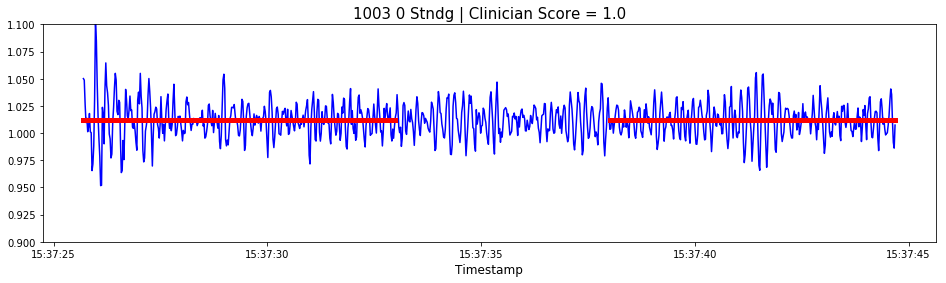

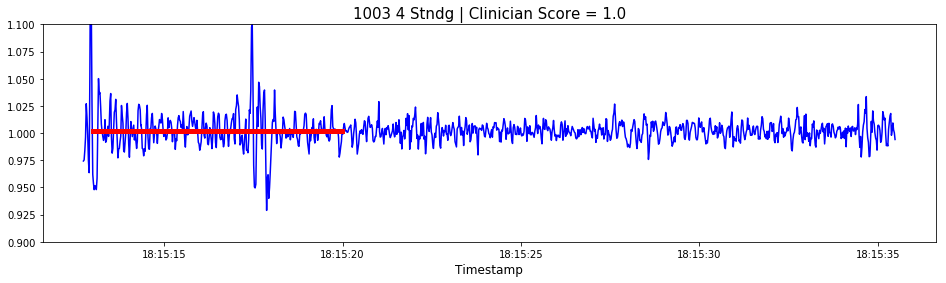

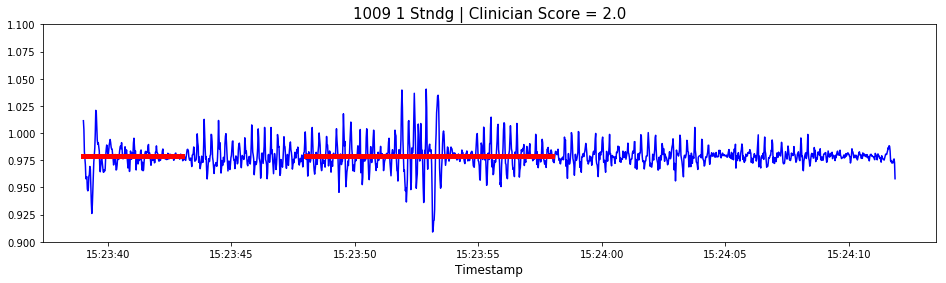

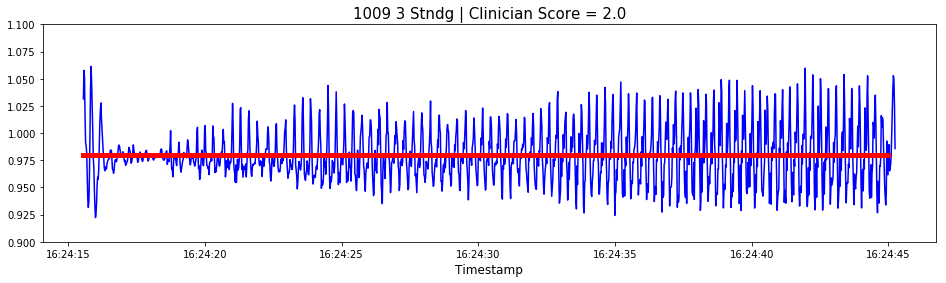

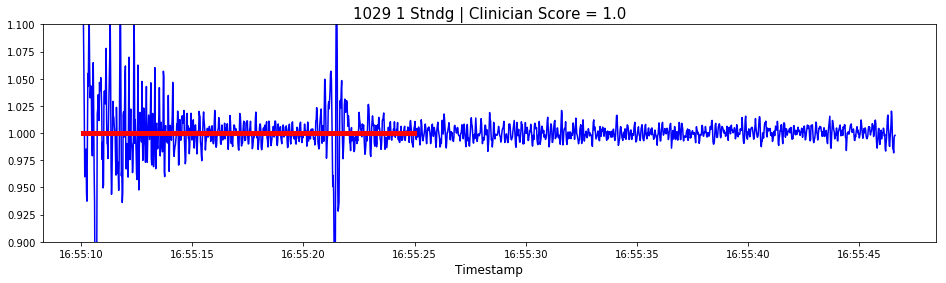

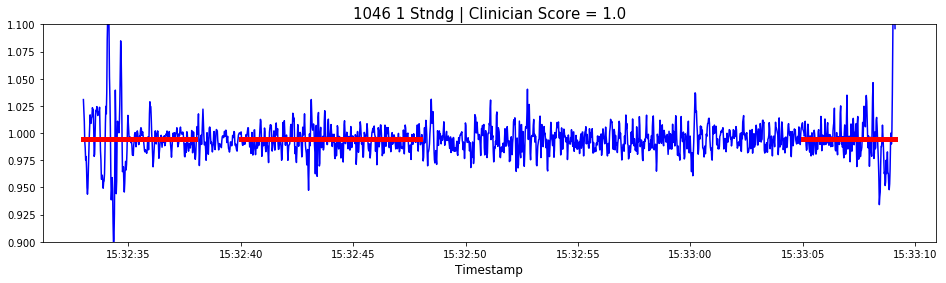

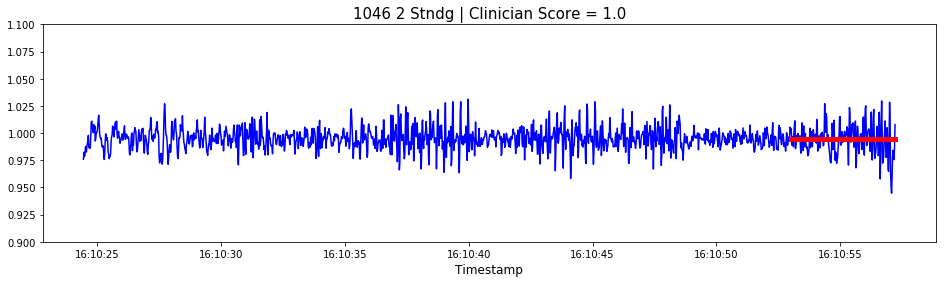

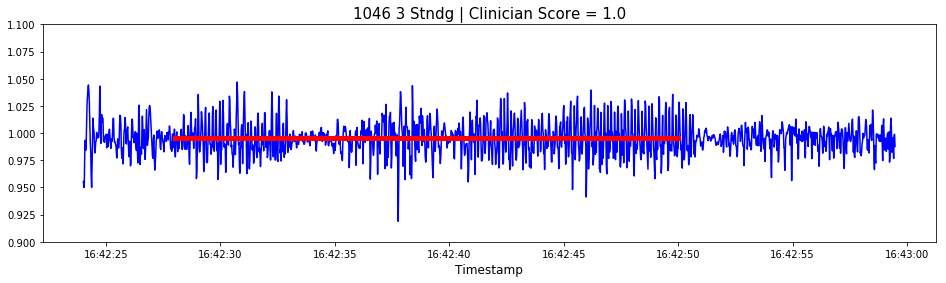

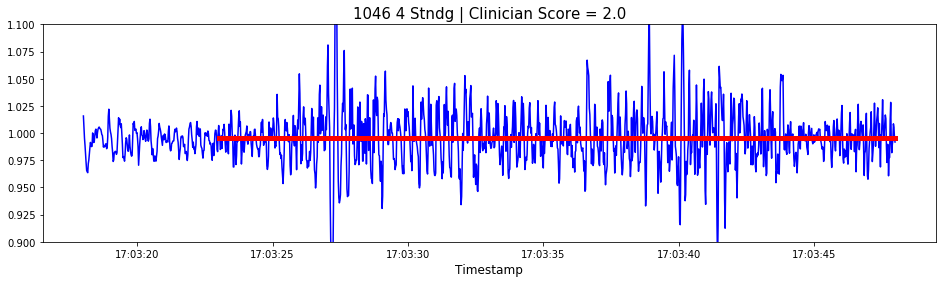

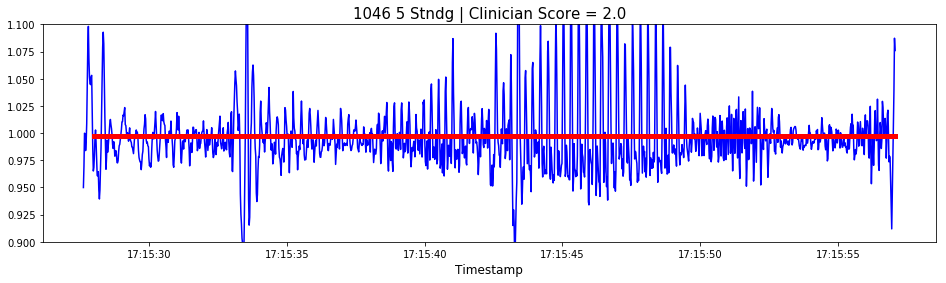

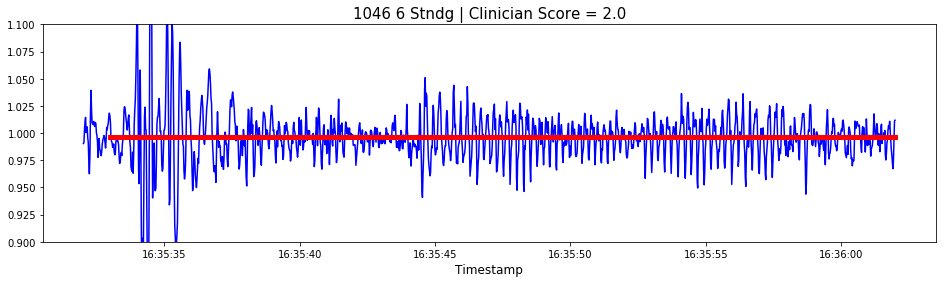

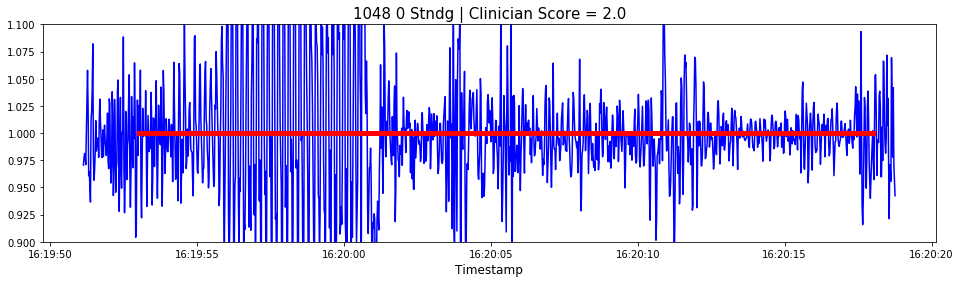

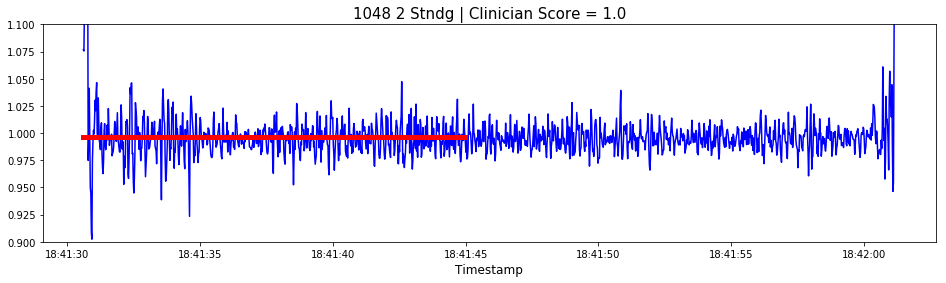

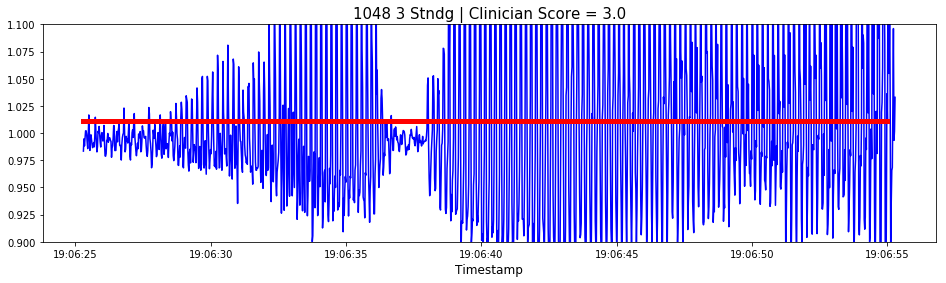

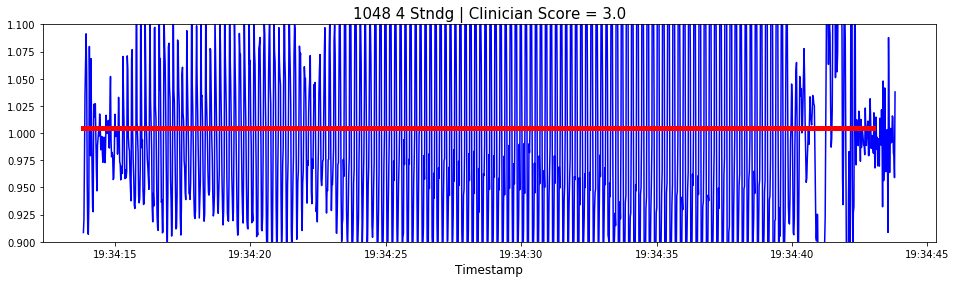

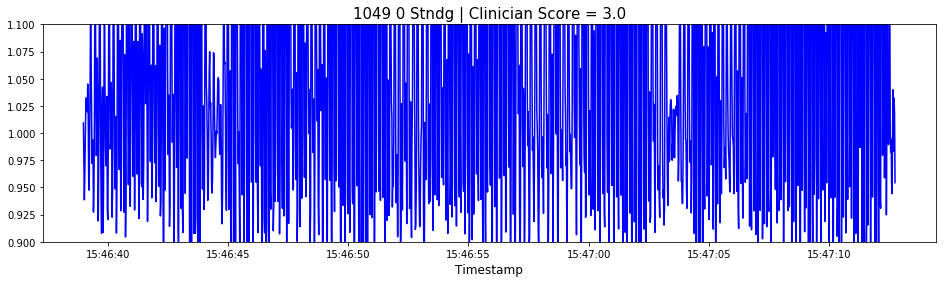

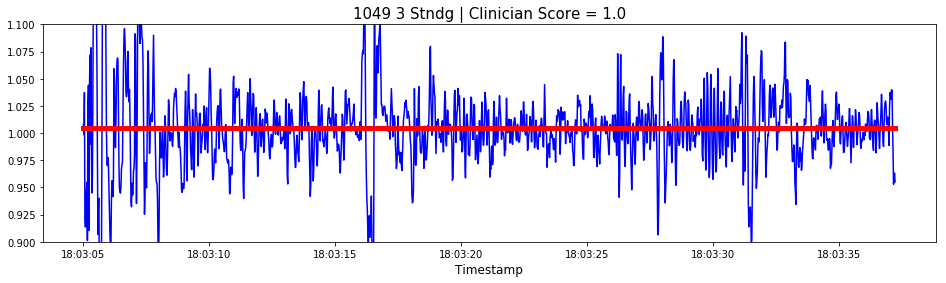

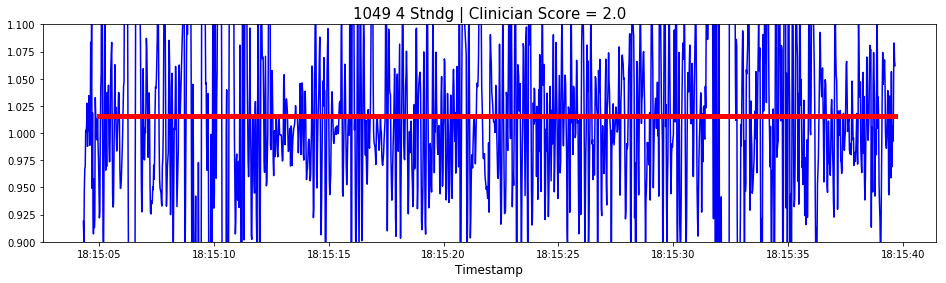

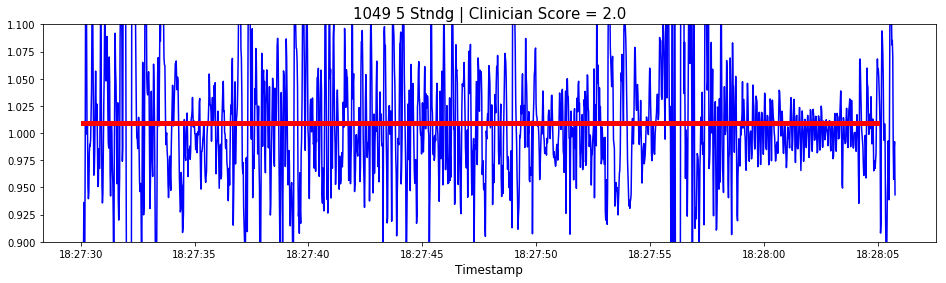

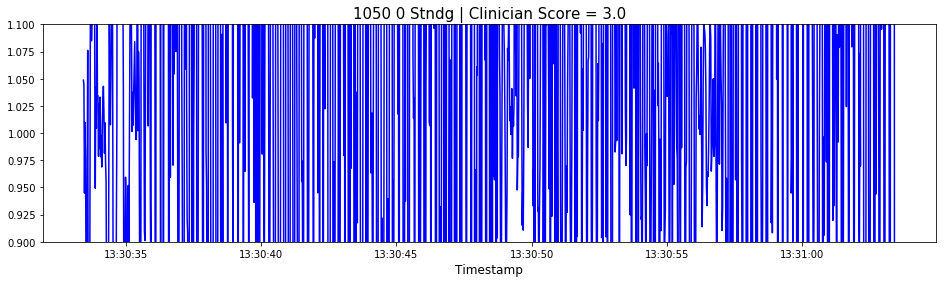

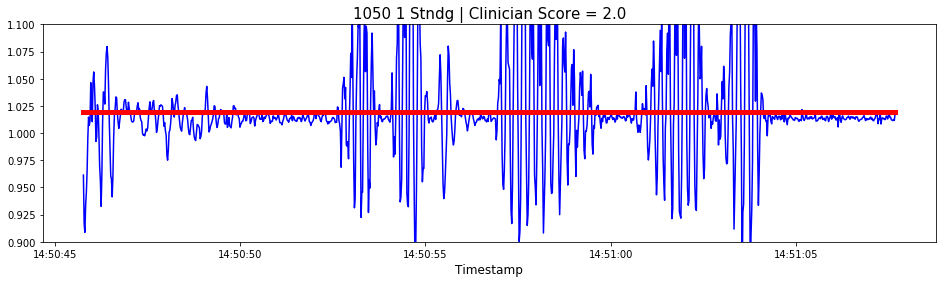

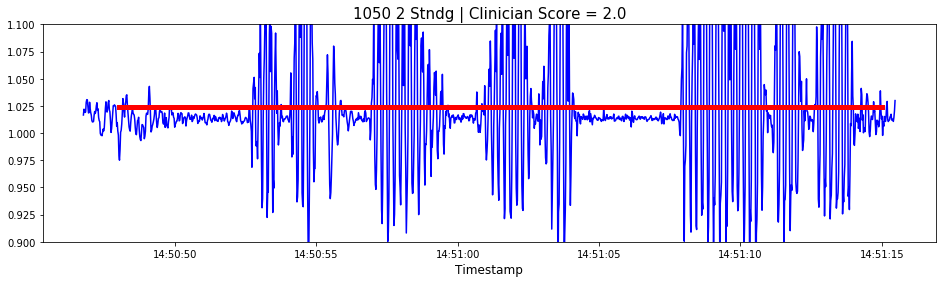

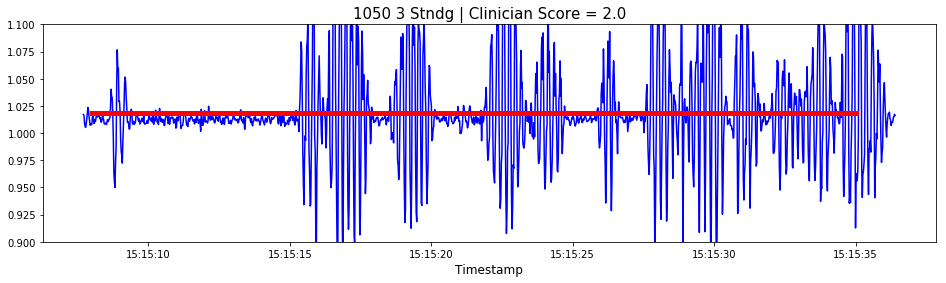

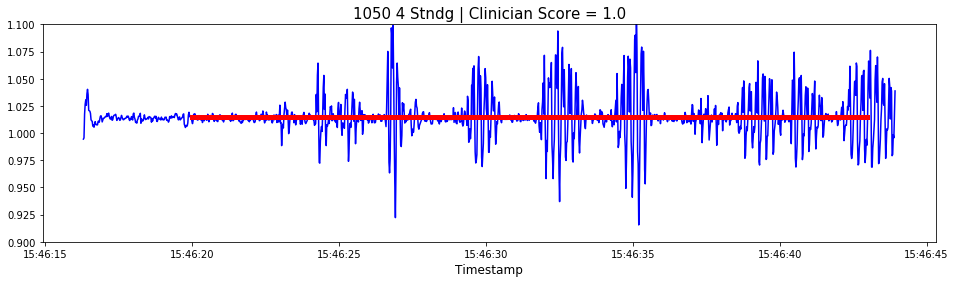

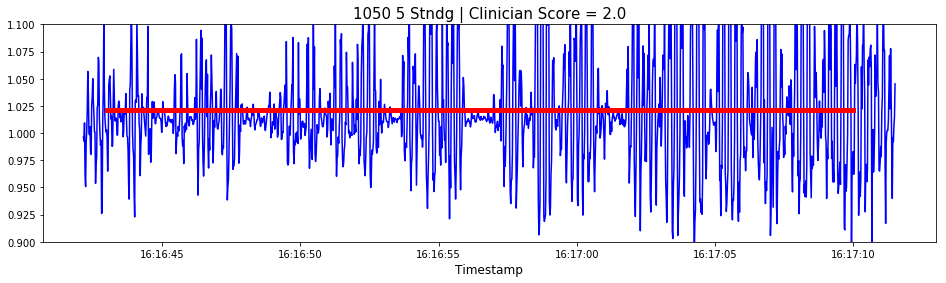

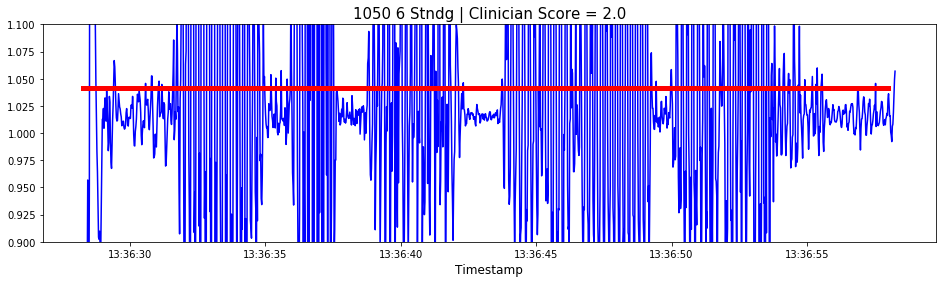

In [273]:
AnomalyClips = DataFeatures[(DataFeatures.Anomaly == 1) & (DataFeatures.Tremor > 0)]
for task in AnomalyClips.TaskAbb.unique():
    TAnomalyClips = AnomalyClips[AnomalyClips.TaskAbb == task]
    for sub in TAnomalyClips.SubjID.unique():
        TSAnomalyClips = TAnomalyClips[TAnomalyClips.SubjID == sub]
        for visit in TSAnomalyClips.Visit.unique():
            TSVAnomalyClips = TSAnomalyClips[TSAnomalyClips.Visit == visit]
            accdata = pd.read_csv(os.path.join(path, 'TaskAcc',
                                               str(int(sub)) + '_' + str(visit) + '_' + task + '.csv'), 
                                  parse_dates = ['timestamp'])[['timestamp', 'x', 'y', 'z']]
            accdata['mag'] = np.sqrt((accdata.x)**2 + (accdata.y)**2 + (accdata.z)**2)
            SVClips = pd.DataFrame()
            plt.figure(figsize = (16, 4))
            plt.plot(accdata.timestamp, accdata['mag'].values, 'b')
            for clip in TSVAnomalyClips.iterrows():
                clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                                   str(int(sub)) + '_' + str(visit) + '_' + 
                                                   clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                                       parse_dates = ['Timestamp'])[['Timestamp']]
                plt.plot(clipacc.values, [np.mean(accdata['mag'].values)] * len(clipacc.values), 'r', linewidth = 5)
            plt.xlabel('Timestamp', fontsize = 12)
            plt.ylim(0.9, 1.1)
            plt.title(str(int(sub)) + ' ' + str(visit) + ' ' + TSVAnomalyClips.TaskAbb.iloc[-1] + ' | '
                      'Clinician Score = ' + str(TSVAnomalyClips.Tremor.iloc[-1]), fontsize = 15)
            plt.show()

In [267]:
DataFeatures[(DataFeatures.SubjID == 1046) & 
             (DataFeatures.Visit == 5) & 
             (DataFeatures.TaskAbb == 'Stndg')]

SubjID  Visit TaskAbb  Clip  Tremor      RMSX      RMSY      RMSZ  \
587    1046      5   Stndg     0     2.0  0.000989  0.001992  0.001983   
588    1046      5   Stndg     1     2.0  0.001737  0.002147  0.001857   
589    1046      5   Stndg     2     2.0  0.001753  0.002072  0.001828   
590    1046      5   Stndg     4     2.0  0.000807  0.002912  0.001915   
591    1046      5   Stndg     5     2.0  0.001777  0.004458  0.003284   
592    1046      5   Stndg     6     2.0  0.002056  0.006471  0.006150   
593    1046      5   Stndg     7     2.0  0.001488  0.006543  0.006059   
594    1046      5   Stndg     8     2.0  0.000750  0.003822  0.002874   
595    1046      5   Stndg     9     2.0  0.000513  0.002168  0.001221   
596    1046      5   Stndg    10     2.0  0.001394  0.001840  0.001236   

       rangeX    rangeY  ...     Sen_Y     Sen_Z   RMS_mag  range_mag  \
587  0.148582  0.231156  ...  1.242900  1.078861  0.001106   0.146014   
588  0.267929  0.211951  ...  1.661174  1.320760  0.001914   0.259273   
589  0.264455  0.212286  ...  1.291086  1.198312  0.001966   0.253878   
590  0.085503  0.309967  ...  1.515705  1.589939  0.001408   0.139814   
591  0.267977  0.461255  ...  1.418730  1.211378  0.002494   0.313368   
592  0.270346  0.492403  ...  1.037988  0.831518  0.003600   0.310230   
593  0.142608  0.543347  ...  0.982237  0.825968  0.003214   0.215338   
594  0.081007  0.432933  ...  1.576051  1.205624  0.001707   0.189058   
595  0.048701  0.227582  ...  1.366037  1.633447  0.000870   0.088387   
596  0.159835  0.187379  ...  1.384670  1.572194  0.001516   0.186387   

     mean_mag   var_mag  skew_mag   kurt_mag   Sen_mag  Anomaly  
587 -0.000698  0.017473  0.971103   5.403350  1.326634      1.0  
588  0.000304  0.030256  0.292972   6.304556  1.047613      1.0  
589  0.001409  0.031047  0.628732   5.490608  0.831124      1.0  
590 -0.000019  0.022270  1.076272   2.147536  1.637377      1.0  
591  0.000054  0.039440  1.272513   4.292304  1.270836      1.0  
592  0.001227  0.056916  1.089630   0.524927  0.983181      1.0  
593 -0.000909  0.050812  1.091423   0.303731  0.924631      1.0  
594  0.001180  0.026960  1.764079   5.427480  1.443662      1.0  
595 -0.000619  0.013750 -0.181427   0.720955  1.758569      1.0  
596 -0.001616  0.021597 -2.493304  11.950671  0.930182      1.0  

[10 rows x 54 columns]

# Classify Clips as Anomaly

In [224]:
def CatchAnomalyModel(label_type, tasks, newLab, groups):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
    features_list = list(DataFeatures.columns[5:53])
    X = DataFeatures[features_list].values
    if newLab:
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = DataFeatures[label_type].values
    le.fit(Y)
    Y = le.transform(Y)
    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    plt.figure(figsize = (12, 10))
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break
            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100    
    if len(groups) == 2:
        plt.show()
        plt.figure(figsize = (12, 10))
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_, annot = True)
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('Test', fontsize = 12)
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    return cf, FeatImp, TestPred, DataFeatures

<Figure size 864x720 with 0 Axes>

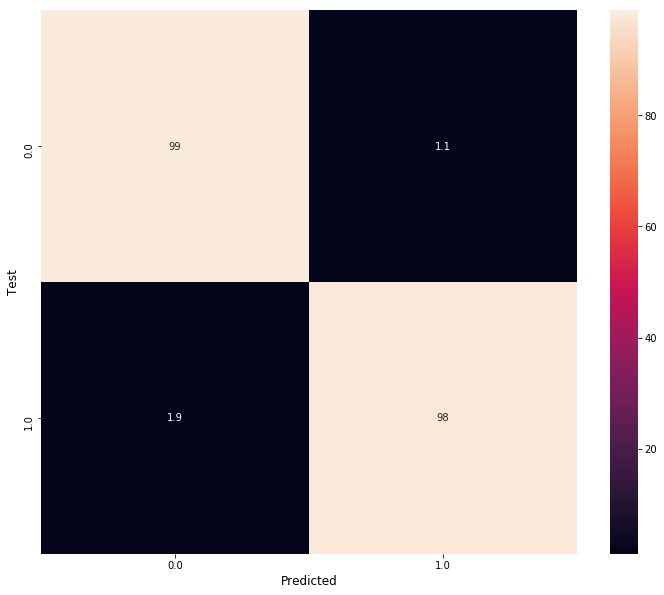

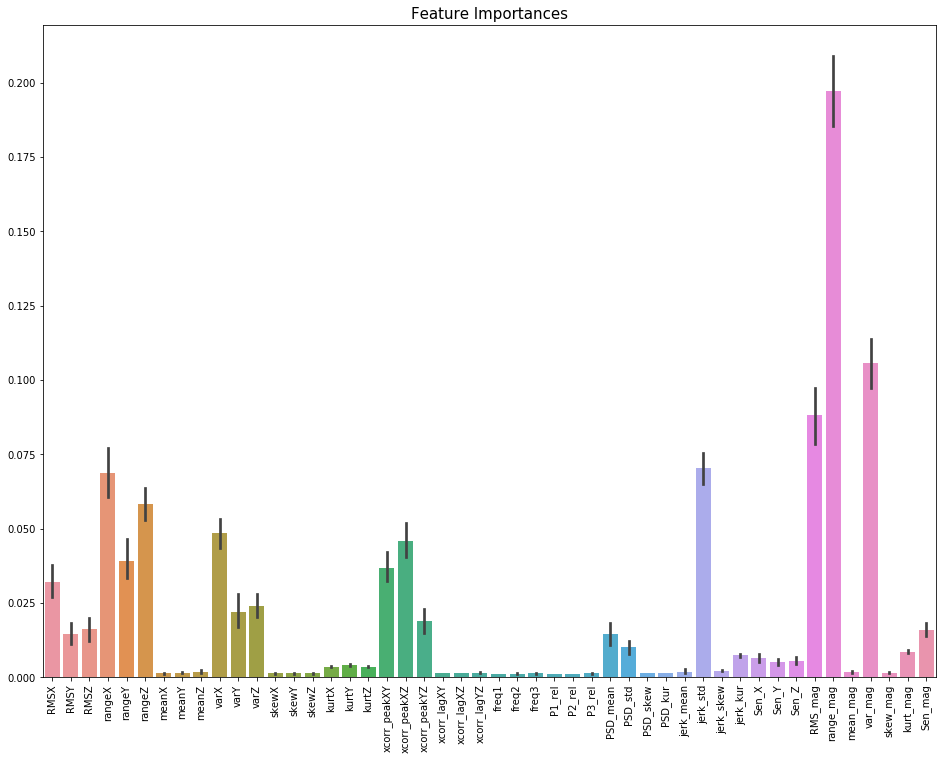

In [225]:
model, FeatImp, TestPred, DataFeatures = CatchAnomalyModel('Anomaly', 
                                                             ['Stndg', 'Sitng'], 
                                                             [], [])

# Classify Anomaly Clips as Symptomatic

In [226]:
def DiscernAnomalyModel(label_type, tasks, newLab, groups):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    DataFeatures = (DataFeatures[DataFeatures.Anomaly == 1]).reset_index(drop = True)
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
    features_list = list(DataFeatures.columns[5:53])
    X = DataFeatures[features_list].values
    if newLab:
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = DataFeatures[label_type].values
    le.fit(Y)
    Y = le.transform(Y)
    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    plt.figure(figsize = (12, 10))
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break
            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100 
    if len(groups) == 2:
        plt.show()
        plt.figure(figsize = (12, 10))
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_, annot = True)
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('Test', fontsize = 12)
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    return cf, FeatImp, TestPred, DataFeatures

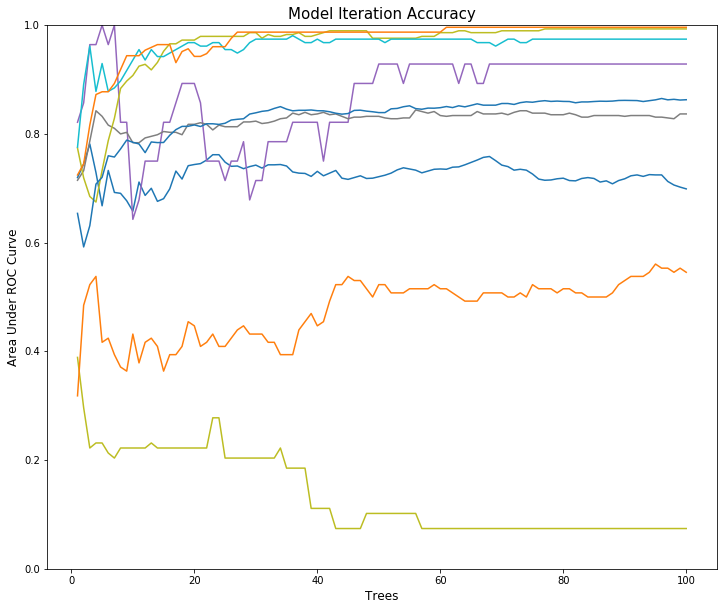

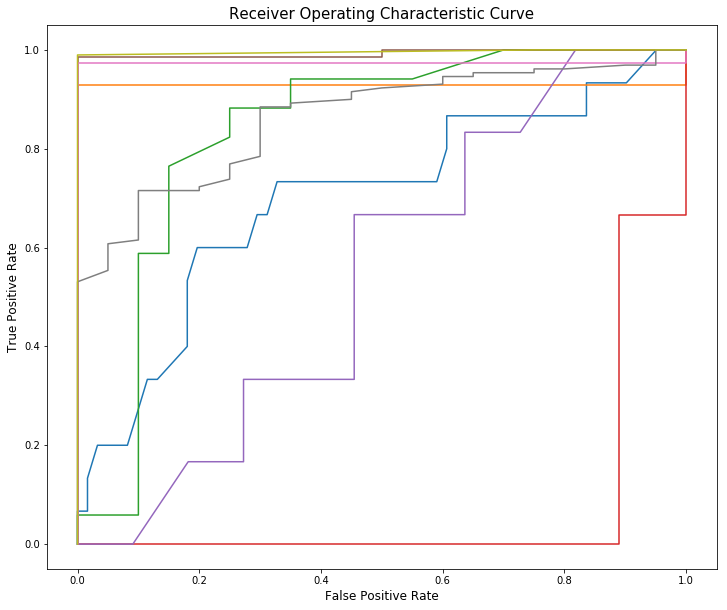

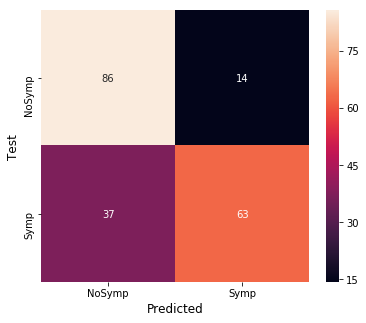

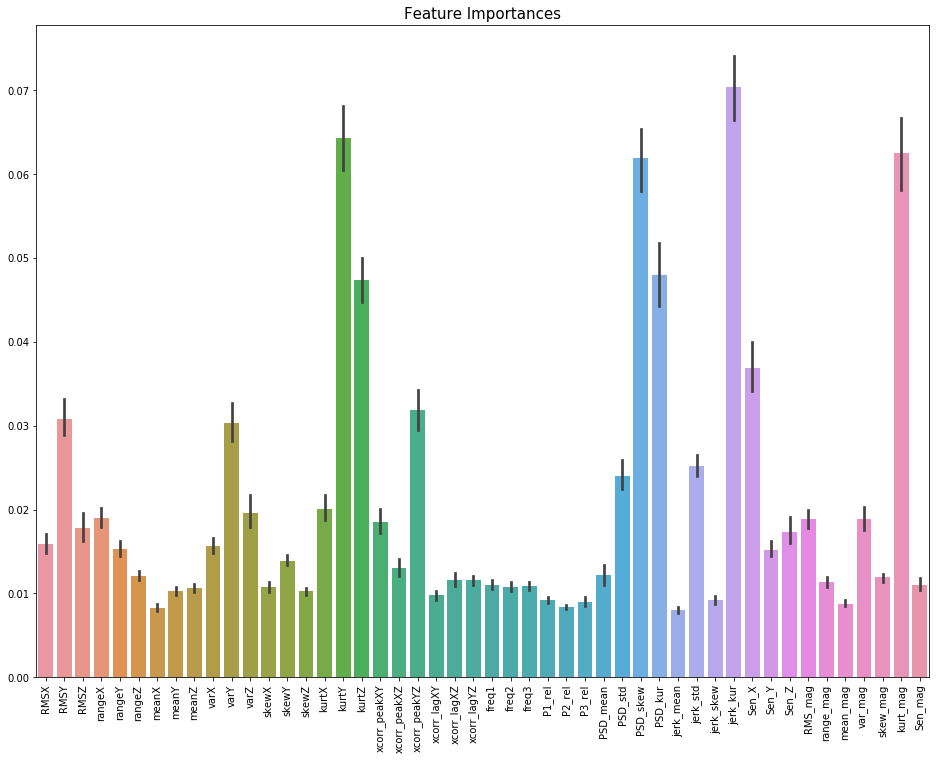

In [264]:
model, FeatImp, TestPred, DataFeatures = DiscernAnomalyModel('Tremor', 
                                                             ['Stndg', 'Sitng'], 
                                                             ['NoSymp', 'Symp'], 
                                                             [[float(0)], [float(1), float(2), float(3), float(4)]])

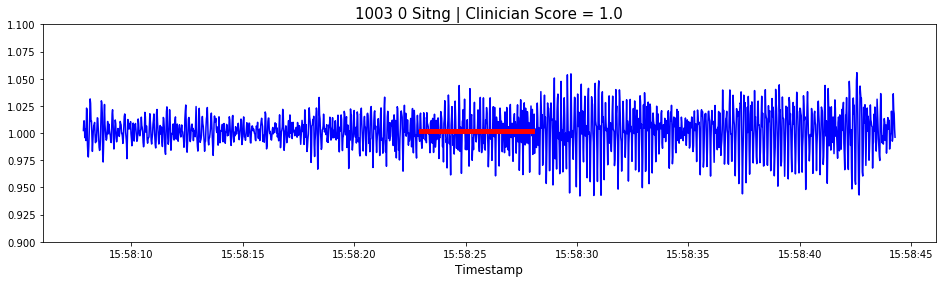

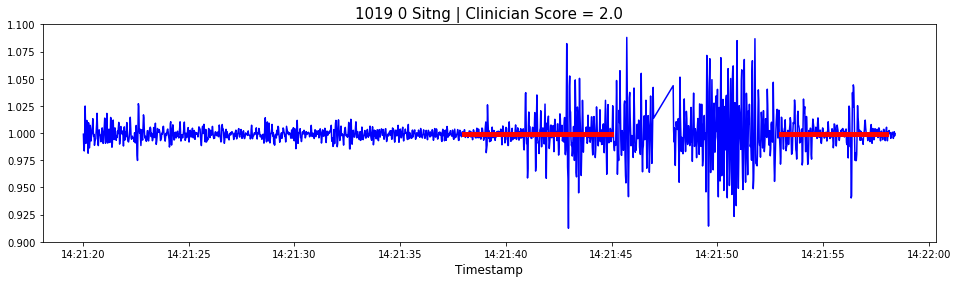

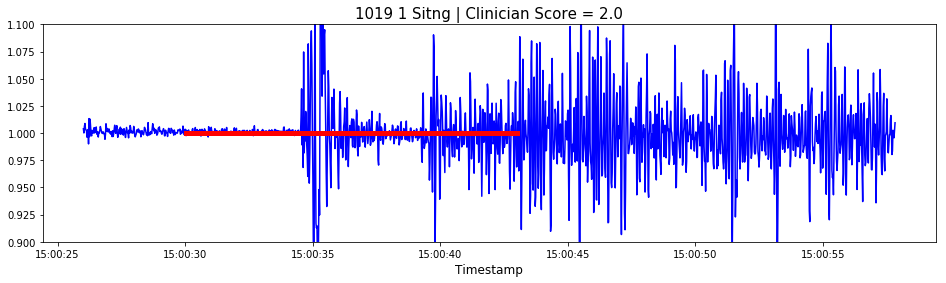

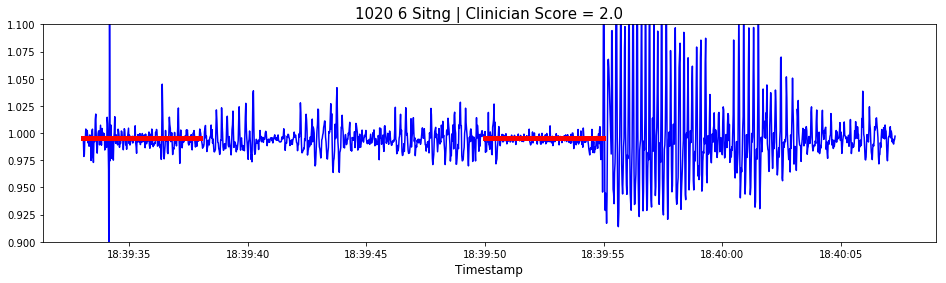

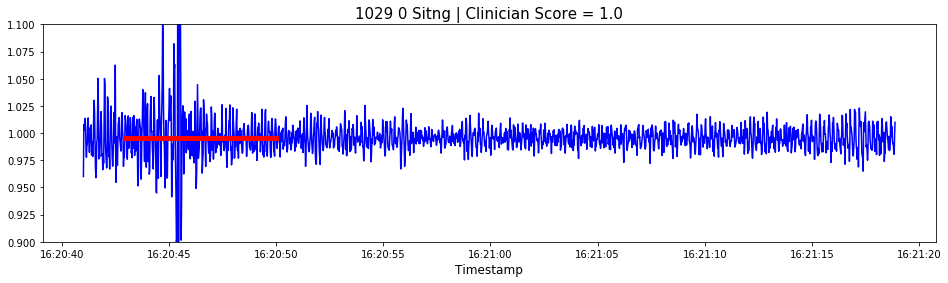

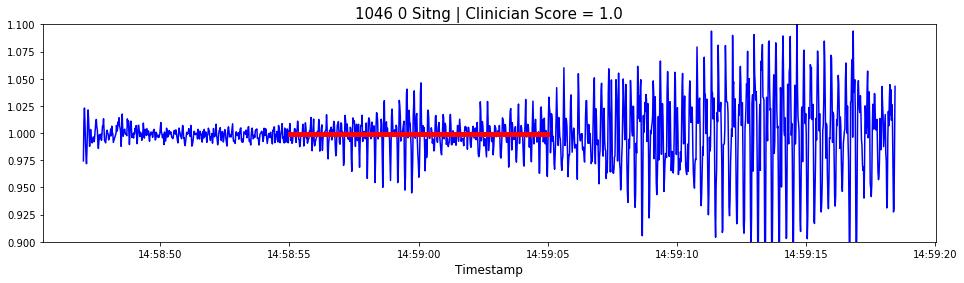

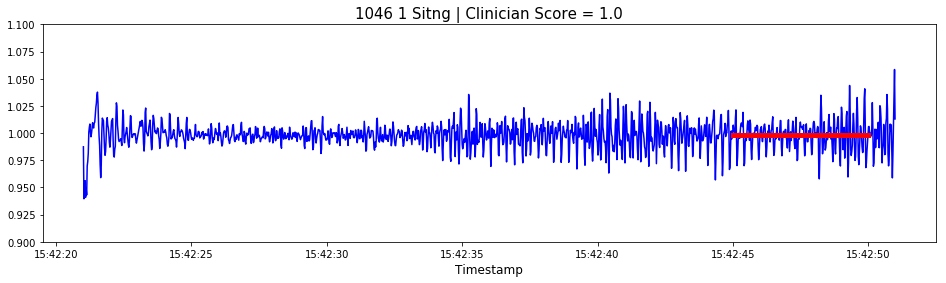

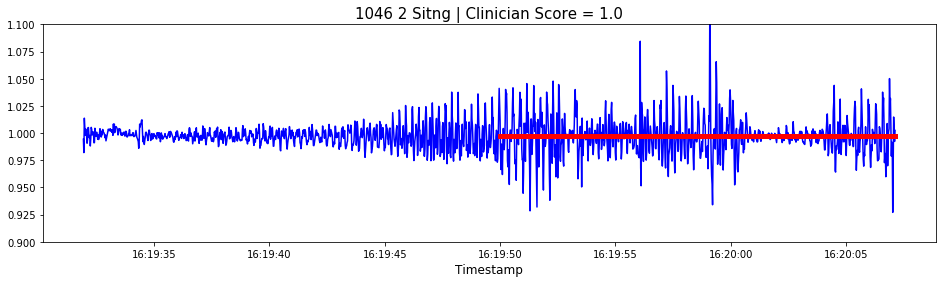

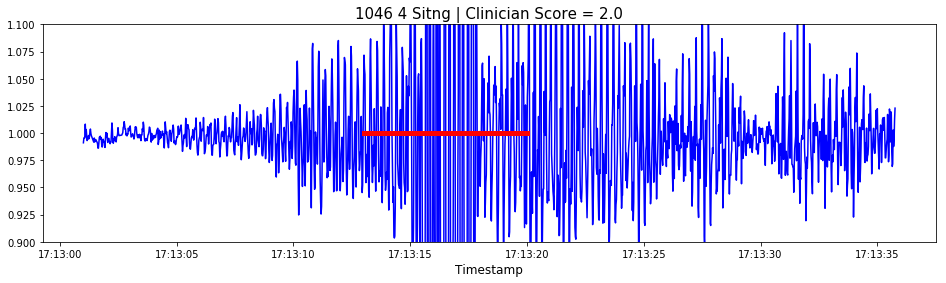

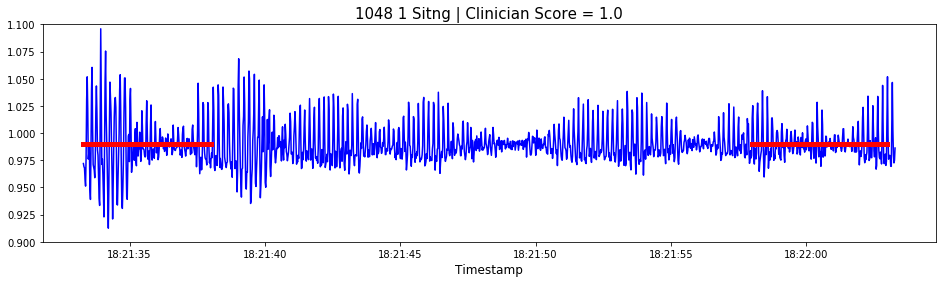

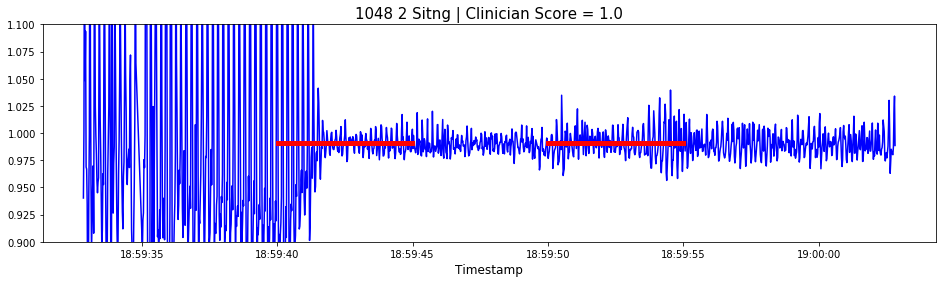

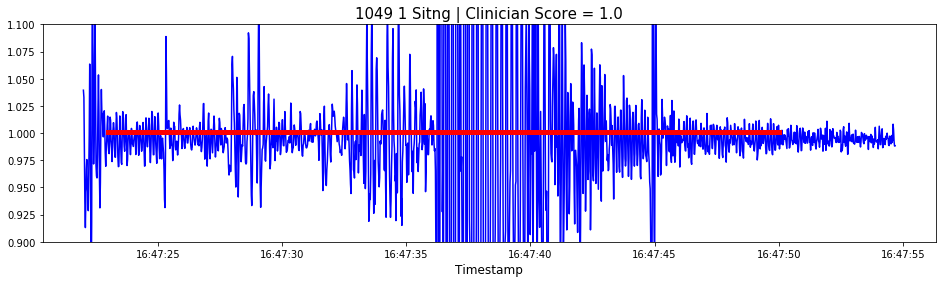

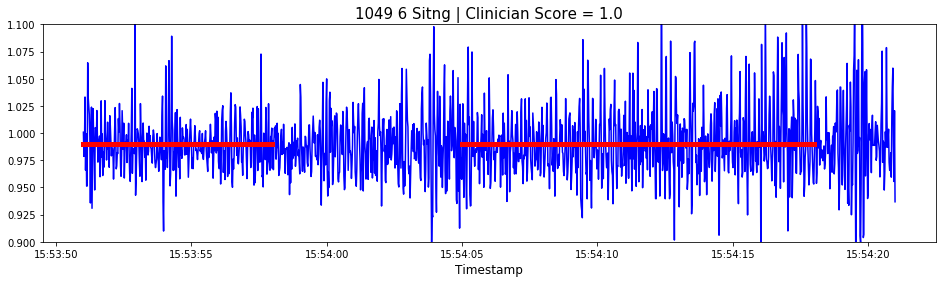

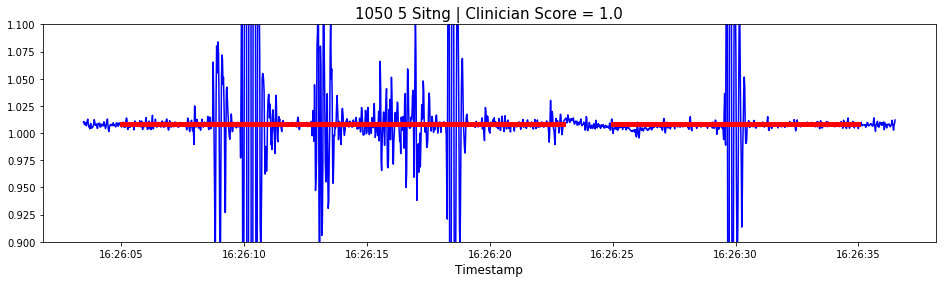

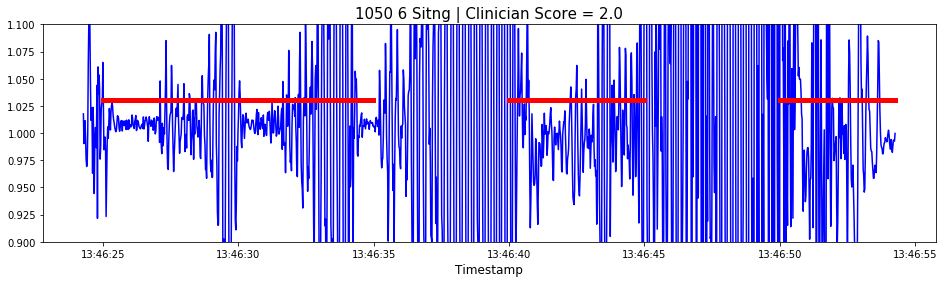

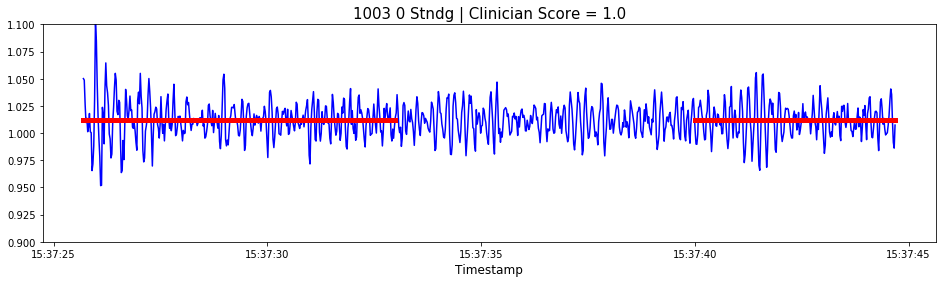

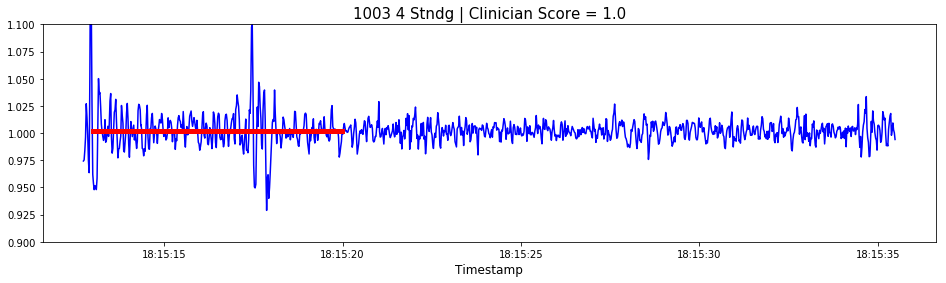

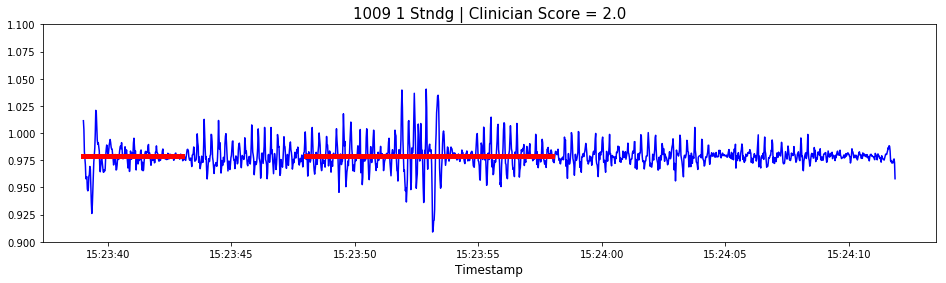

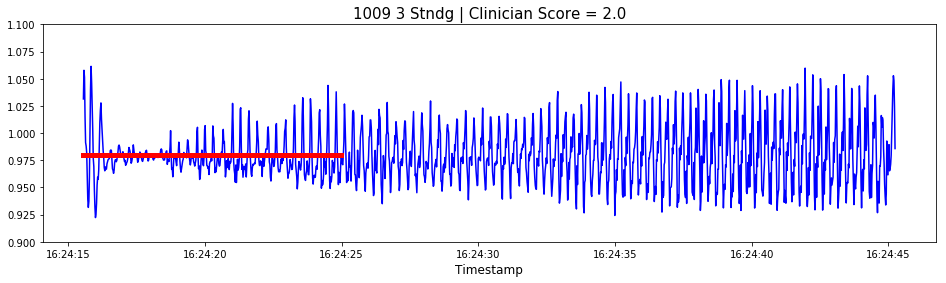

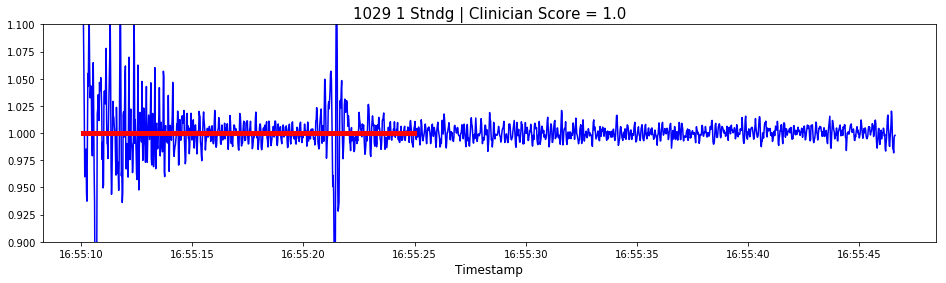

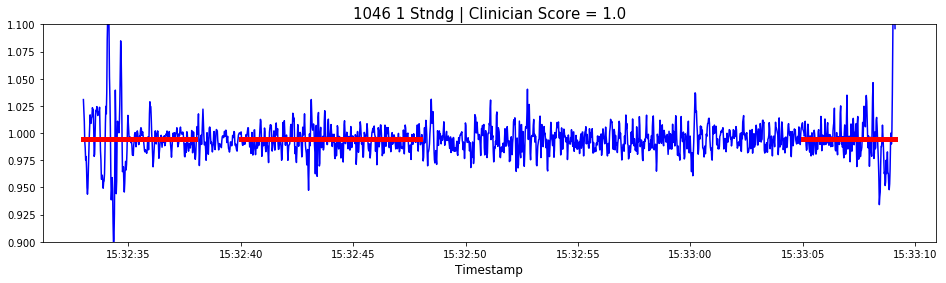

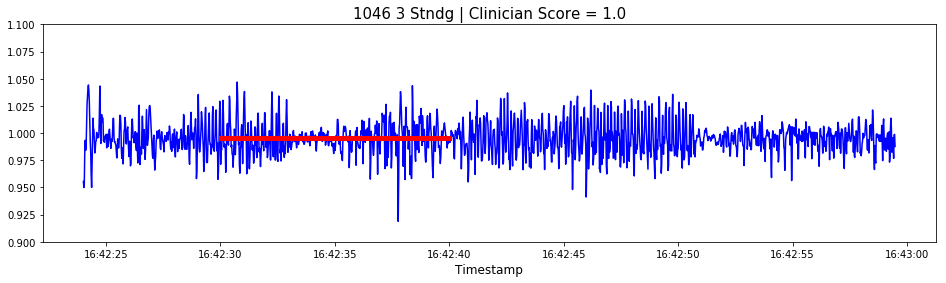

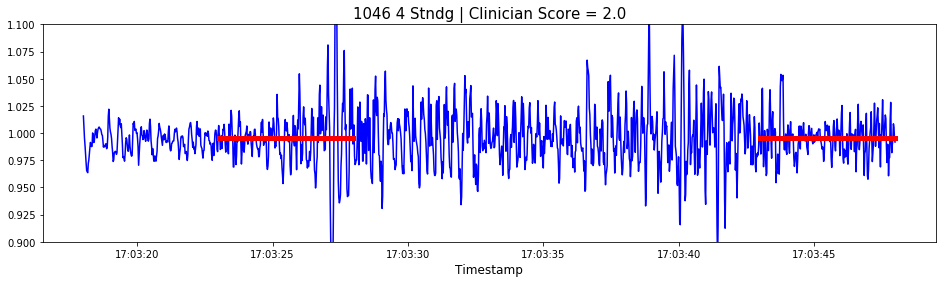

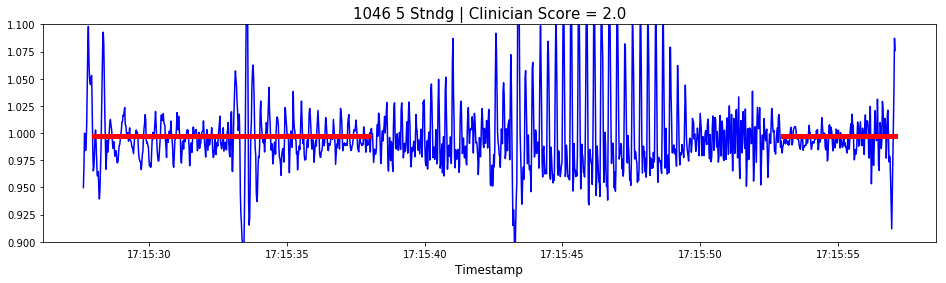

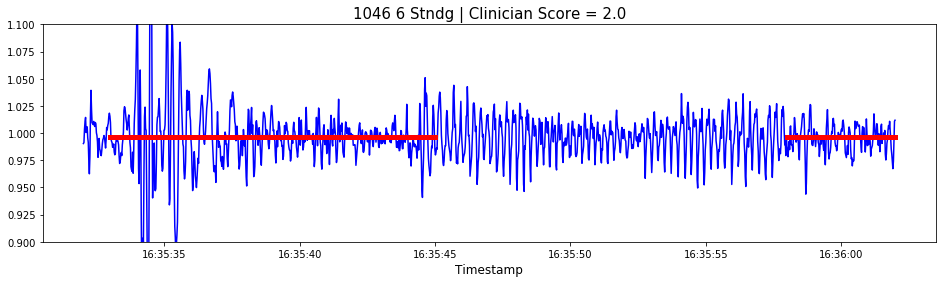

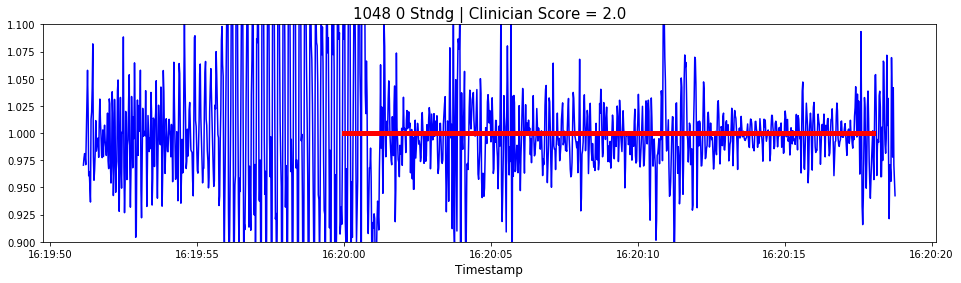

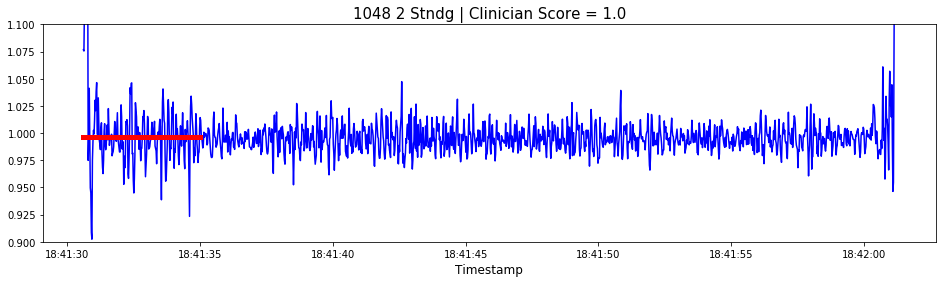

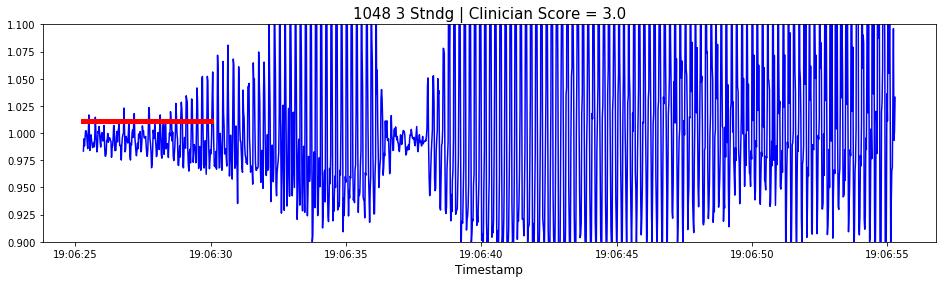

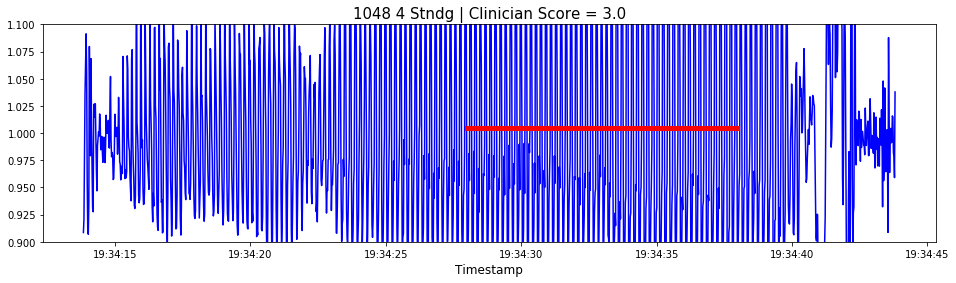

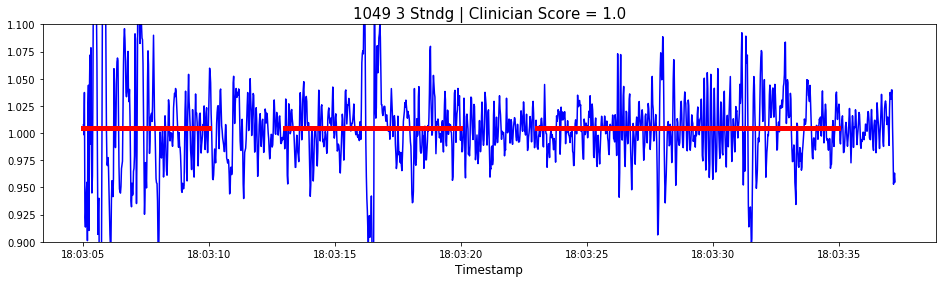

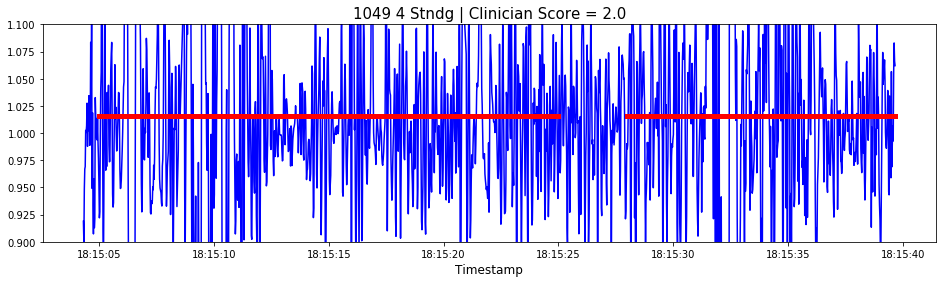

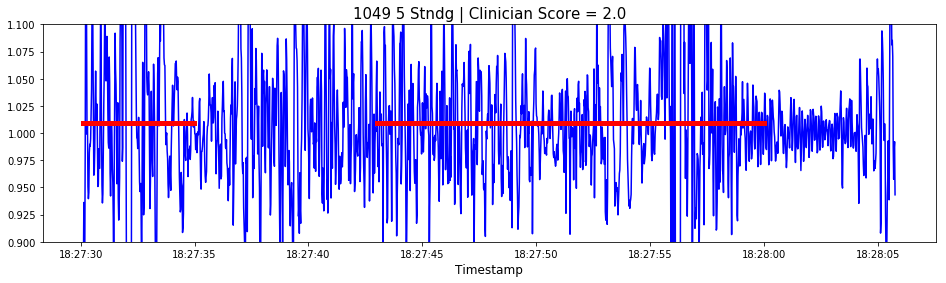

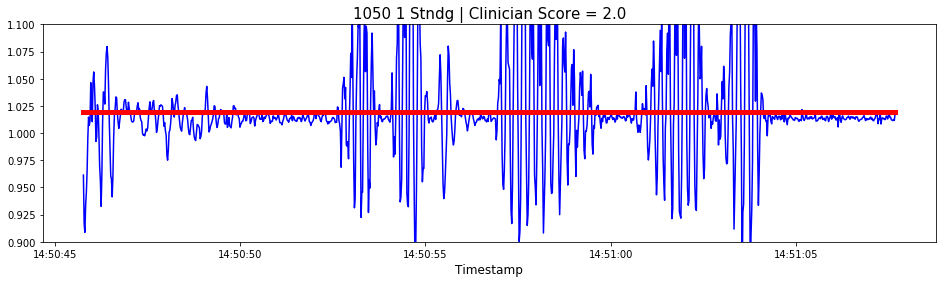

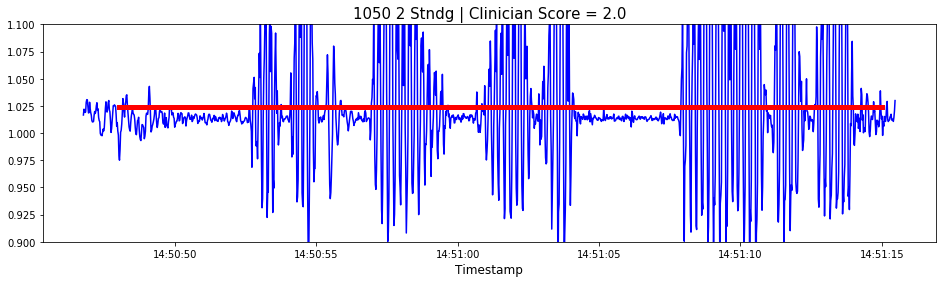

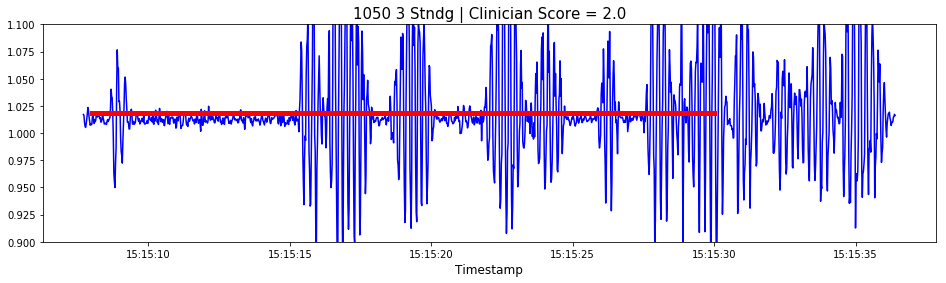

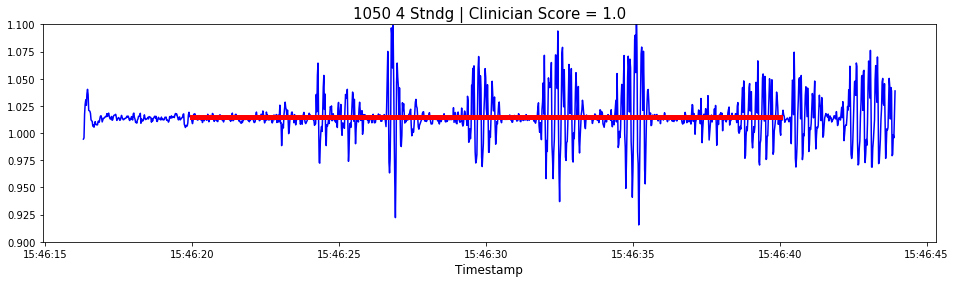

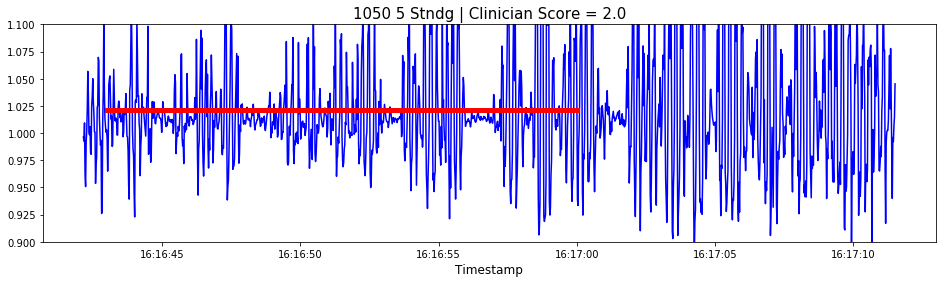

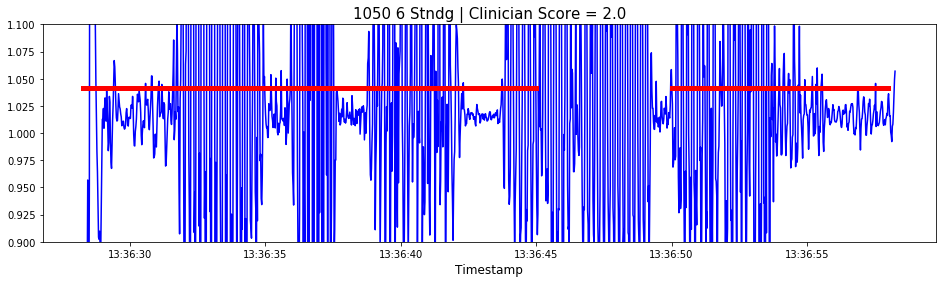

In [274]:
FalseNegatives = DataFeatures[(TestPred.TestLabs == 'Symp') & (TestPred.PredLabs == 'NoSymp')]
for task in FalseNegatives.TaskAbb.unique():
    TFalseNegatives = FalseNegatives[FalseNegatives.TaskAbb == task]
    for sub in TFalseNegatives.SubjID.unique():
        TSFalseNegatives = TFalseNegatives[TFalseNegatives.SubjID == sub]
        for visit in TSFalseNegatives.Visit.unique():
            TSVFalseNegatives = TSFalseNegatives[TSFalseNegatives.Visit == visit]
            accdata = pd.read_csv(os.path.join(path, 'TaskAcc',
                                               str(int(sub)) + '_' + str(visit) + '_' + task + '.csv'), 
                                  parse_dates = ['timestamp'])[['timestamp', 'x', 'y', 'z']]
            accdata['mag'] = np.sqrt((accdata.x)**2 + (accdata.y)**2 + (accdata.z)**2)
#             accdata.loc[:, ['x', 'y', 'z', 'mag']] = filterdata(accdata[['x', 'y', 'z', 'mag']])
            SVClips = pd.DataFrame()
            plt.figure(figsize = (16, 4))
            plt.plot(accdata.timestamp, accdata['mag'].values, 'b')
            for clip in TSVFalseNegatives.iterrows():
                clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                                   str(int(sub)) + '_' + str(visit) + '_' + 
                                                   clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                                       parse_dates = ['Timestamp'])[['Timestamp']]
                plt.plot(clipacc.values, [np.mean(accdata['mag'].values)] * len(clipacc.values), 'r', linewidth = 5)
            plt.xlabel('Timestamp', fontsize = 12)
            plt.ylim(0.9, 1.1)
            plt.title(str(int(sub)) + ' ' + str(visit) + ' ' + TSVFalseNegatives.TaskAbb.iloc[-1] + ' | '
                      'Clinician Score = ' + str(TSVFalseNegatives.Tremor.iloc[-1]), fontsize = 15)
            plt.show()

# Predict Presence of Anomaly and Detect Symptom in those Clips

In [228]:
def DetectDiscernAnomalyModel(label_type, tasks, newLab, groups):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    
    
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    features_list = list(DataFeatures.columns[5:53])
    X = DataFeatures[features_list].values
    Y = DataFeatures['Anomaly'].values
    le.fit(Y)
    Y = le.transform(Y)
    j = True
    k = True
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    
    
    
    # only look at clips predicted to have an anomaly present
    # find a way to predict anomaly finder first and only train/test on those predicted to have anomaly immediately
    # is this doing the same thing?
    DataFeatures = DataFeatures[TestPred.PredLabs == 1]
    
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
    features_list = list(DataFeatures.columns[5:53])
    X = DataFeatures[features_list].values
    if newLab:
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = DataFeatures[label_type].values
    le.fit(Y)
    Y = le.transform(Y)
    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    j = True
    k = True
    plt.figure(figsize = (12, 10))
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]
        TestFeat = X[testInd]
        TestLab = Y[testInd]
        cf.fit(TrainFeat, TrainLab)
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break
            if j:
                ProbLabCV = [list(ProbLab)]
                TestLabCV = [list(TestLab)]
                j = False
            else:
                ProbLabCV = ProbLabCV + [list(ProbLab)]
                TestLabCV = TestLabCV + [list(TestLab)]
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 12)
            plt.ylabel('Area Under ROC Curve', fontsize = 12)
            plt.title('Model Iteration Accuracy', fontsize = 15)
            plt.ylim((0, 1))
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        PredLab = cf.predict(TestFeat)
        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)
        if k:
            TestLabs = list(TestLab)
            PredLabs = list(PredLab)
            testInds = list(testInd)
            k = False
        else:
            TestLabs = TestLabs + list(TestLab)
            PredLabs = PredLabs + list(PredLab)
            testInds = testInds + list(testInd)
        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
    TestPred = pd.DataFrame(index = testInds)
    TestPred['TestLabs'] = TestLabs
    TestPred['PredLabs'] = PredLabs
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100 
    if len(groups) == 2:
        plt.show()
        plt.figure(figsize = (12, 10))
        for PL, TL in zip(ProbLabCV, TestLabCV):
            if len(set(TL)) == 1:
                continue
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate', fontsize = 12)
            plt.ylabel('True Positive Rate', fontsize = 12)
            plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
        plt.show()
    if len(groups) == 2:
        plt.figure(figsize = (6, 5))
    else:
        plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_, annot = True)
    plt.xlabel('Predicted', fontsize = 12)
    plt.ylabel('Test', fontsize = 12)
    plt.figure(figsize = (16, 12))
    sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
    plt.xticks(rotation = 90)
    plt.title('Feature Importances', fontsize = 15)
    
    return cf, FeatImp, TestPred, DataFeatures

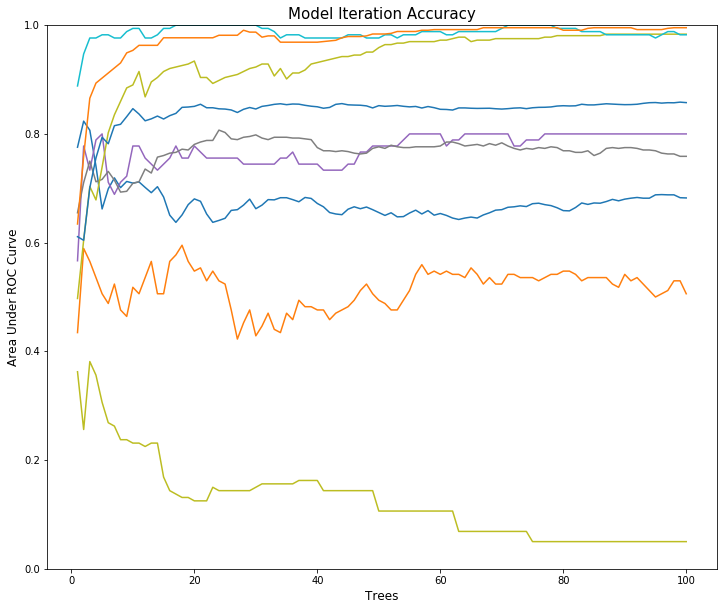

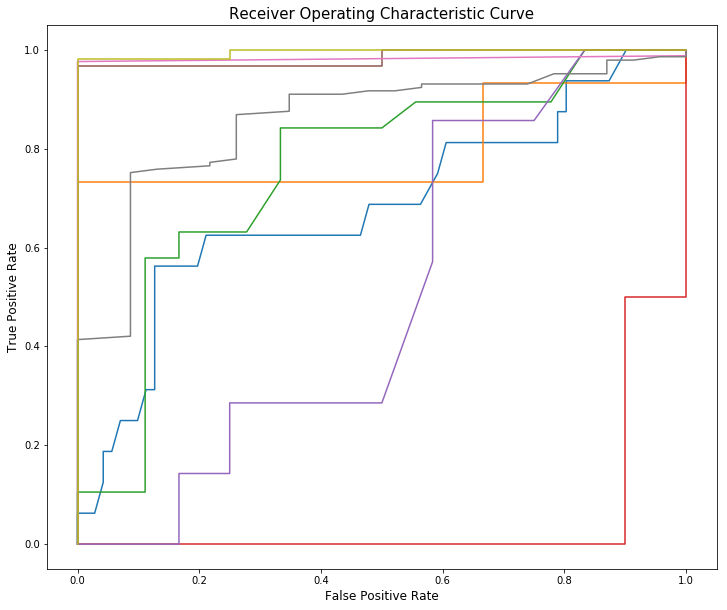

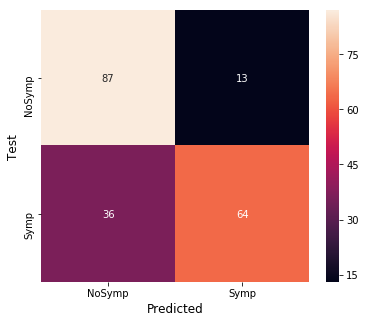

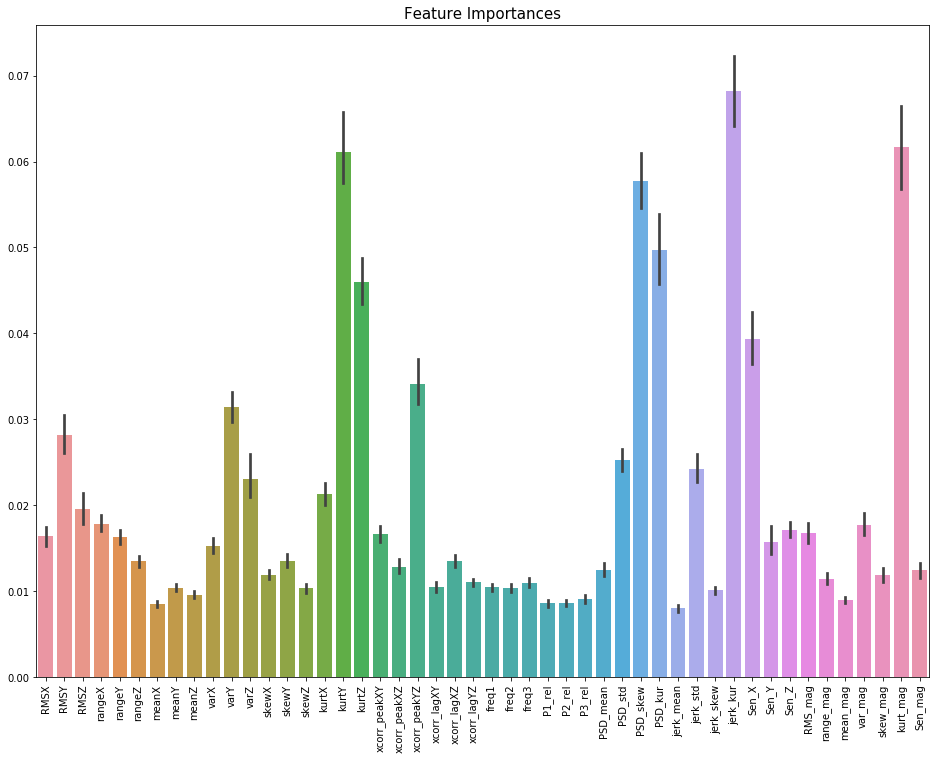

In [229]:
model, FeatImp, TestPred, DataFeatures = DetectDiscernAnomalyModel('Tremor', 
                                                                   ['Stndg', 'Sitng'], 
                                                                   ['NoSymp', 'Symp'], 
                                                                   [[float(0)], [float(1), float(2), float(3), float(4)]])

In [61]:
# DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
# for task in DataFeatures.TaskAbb.unique():
#     TDataFeatures = DataFeatures[DataFeatures.TaskAbb == task]
#     for subj in TDataFeatures.SubjID.unique():
#         TSDataFeatures = TDataFeatures[TDataFeatures.SubjID == subj]
#         for visit in TSDataFeatures.Visit.unique():
#             TSVDataFeatures = TSDataFeatures[TSDataFeatures.Visit == visit]
#             if any(TSVDataFeatures.Tremor == 1) and any(TSVDataFeatures.Anomaly == 0):
#                 print(str(int(TSVDataFeatures.SubjID.iloc[-1])) + '_' + 
#                       str(TSVDataFeatures.Visit.iloc[-1]) + '_' + TSVDataFeatures.TaskAbb.iloc[-1])
                
                
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
TremAnom = DataFeatures[(DataFeatures.Anomaly == 1) & (DataFeatures.Tremor == 1)]
NoSympAnom = DataFeatures[(DataFeatures.Anomaly == 1) & (DataFeatures.Tremor == 0)]
ClipAccTA = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', '1049_3_Stndg_11.csv'), 
                        parse_dates = ['Timestamp'])
ClipAccTA['Accel_Mag'] = ((ClipAccTA[['X', 'Y', 'Z']]**2).sum(axis = 1))
Fs = np.mean(1/(np.diff(ClipAccTA.Accel_Mag.index)/1000))
f,Pxx_den = welch(ClipAccTA.Accel_Mag,Fs,nperseg=min(256,len(ClipAccTA.Accel_Mag)))
Pxxdf = pd.DataFrame(data=Pxx_den,index=f,columns=['PSD_magnitude'])
Pxxdf

PSD_magnitude
0.000000     2.580587e-07
4.672897     1.865969e-07
9.345794     2.336039e-07
14.018692    2.062982e-06
18.691589    3.074381e-06
23.364486    1.881950e-06
28.037383    1.456061e-05
32.710280    3.537763e-05
37.383178    1.379690e-05
42.056075    4.153620e-06
46.728972    5.009524e-06
51.401869    8.625506e-06
56.074766    9.584071e-07
60.747664    5.581426e-07
65.420561    5.990993e-08
70.093458    3.038144e-07
74.766355    4.550363e-07
79.439252    9.548443e-07
84.112150    3.938528e-07
88.785047    1.983696e-06
93.457944    1.244180e-06
98.130841    1.127873e-07
102.803738   1.437037e-08
107.476636   7.312965e-07
112.149533   3.190190e-06
116.822430   2.430057e-06
121.495327   1.209493e-06
126.168224   1.232313e-06
130.841121   1.822401e-06
135.514019   1.378415e-06
...                   ...
364.485981   1.172292e-07
369.158879   1.347686e-07
373.831776   2.505066e-07
378.504673   8.355520e-08
383.177570   2.233142e-08
387.850467   1.089030e-07
392.523364   1.538029e-07
397.196262   1.118234e-07
401.869159   7.125703e-08
406.542056   3.976157e-07
411.214953   2.252527e-07
415.887850   1.865090e-08
420.560748   3.207885e-08
425.233645   3.386217e-08
429.906542   5.301077e-08
434.579439   2.626090e-07
439.252336   3.880063e-08
443.925234   2.974872e-08
448.598131   2.940614e-08
453.271028   3.893496e-08
457.943925   1.939541e-08
462.616822   8.954981e-08
467.289720   1.140074e-07
471.962617   5.282414e-08
476.635514   2.191161e-07
481.308411   6.234932e-08
485.981308   1.470116e-07
490.654206   1.110035e-07
495.327103   3.409781e-08
500.000000   1.662849e-08

[108 rows x 1 columns]

In [211]:
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
for task in DataFeatures.TaskAbb.unique():
    TDataFeatures = DataFeatures[DataFeatures.TaskAbb == task]
    for subj in TDataFeatures.SubjID.unique():
        TSDataFeatures = TDataFeatures[TDataFeatures.SubjID == subj]
        for visit in TSDataFeatures.Visit.unique():
            TSVDataFeatures = TSDataFeatures[TSDataFeatures.Visit == visit]
            if all(TSVDataFeatures.Tremor == 1) and all(TSVDataFeatures.Anomaly == 0):
                print(str(int(TSVDataFeatures.SubjID.iloc[-1])) + '_' + 
                      str(TSVDataFeatures.Visit.iloc[-1]) + '_' + TSVDataFeatures.TaskAbb.iloc[-1])

1003_4_Sitng
1005_2_Sitng
1005_3_Sitng
1046_5_Sitng
1050_1_Sitng
1009_6_Stndg


In [212]:
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'AnomalyFeatures.csv'))
DataFeatures

SubjID  Visit TaskAbb  Clip  Tremor      RMSX      RMSY      RMSZ  \
0     1003.0      0   Sitng     0     1.0  0.000755  0.001049  0.001079   
1     1003.0      0   Sitng     1     1.0  0.000484  0.000754  0.000634   
2     1003.0      0   Sitng     2     1.0  0.000562  0.000662  0.000531   
3     1003.0      0   Sitng     3     1.0  0.000538  0.000592  0.000550   
4     1003.0      0   Sitng     4     1.0  0.000494  0.000642  0.000583   
5     1003.0      0   Sitng     5     1.0  0.000497  0.000703  0.000771   
6     1003.0      0   Sitng     6     1.0  0.000540  0.000710  0.000846   
7     1003.0      0   Sitng     7     1.0  0.000629  0.000874  0.000897   
8     1003.0      0   Sitng     8     1.0  0.000626  0.001077  0.000985   
9     1003.0      0   Sitng     9     1.0  0.000670  0.001303  0.001137   
10    1003.0      0   Sitng    10     1.0  0.000788  0.001158  0.001006   
11    1003.0      0   Sitng    11     1.0  0.000841  0.001140  0.000949   
12    1003.0      0   Sitng    12     1.0  0.000887  0.001233  0.001058   
13    1003.0      0   Sitng    13     1.0  0.000927  0.001423  0.001113   
14    1003.0      0   Sitng    14     1.0  0.000930  0.001363  0.001210   
15    1003.0      0   Stndg     0     1.0  0.001097  0.002338  0.001428   
16    1003.0      0   Stndg     1     1.0  0.000631  0.001161  0.000791   
17    1003.0      0   Stndg     2     1.0  0.000584  0.001210  0.000811   
18    1003.0      0   Stndg     3     1.0  0.000575  0.001160  0.000774   
19    1003.0      0   Stndg     4     1.0  0.000539  0.001092  0.000720   
20    1003.0      0   Stndg     5     1.0  0.000673  0.001009  0.000753   
21    1003.0      0   Stndg     6     1.0  0.000720  0.001067  0.000759   
22    1003.0      0   Stndg     7     1.0  0.001039  0.001612  0.001406   
23    1003.0      1   Sitng     0     0.0  0.011928  0.007735  0.007512   
24    1003.0      1   Sitng     1     0.0  0.011914  0.006870  0.006227   
25    1003.0      1   Sitng     2     0.0  0.012578  0.008003  0.004698   
26    1003.0      1   Sitng     3     0.0  0.011683  0.007644  0.005282   
27    1003.0      1   Sitng     4     0.0  0.008970  0.005023  0.004471   
28    1003.0      1   Sitng     5     0.0  0.011169  0.007857  0.006136   
29    1003.0      1   Sitng     6     0.0  0.009468  0.007168  0.005595   
...      ...    ...     ...   ...     ...       ...       ...       ...   
3421  1051.0      5   Stndg    10     0.0  0.000312  0.000427  0.000346   
3422  1051.0      5   Stndg    11     0.0  0.000439  0.000614  0.000437   
3423  1051.0      5   Stndg    12     0.0  0.000556  0.000747  0.000504   
3424  1051.0      6   Sitng     0     0.0  0.000803  0.001075  0.001170   
3425  1051.0      6   Sitng     1     0.0  0.000381  0.000823  0.000825   
3426  1051.0      6   Sitng     2     0.0  0.000296  0.000217  0.000186   
3427  1051.0      6   Sitng     3     0.0  0.000277  0.000175  0.000208   
3428  1051.0      6   Sitng     4     0.0  0.000171  0.000182  0.000200   
3429  1051.0      6   Sitng     5     0.0  0.000180  0.000195  0.000199   
3430  1051.0      6   Sitng     6     0.0  0.000157  0.000175  0.000164   
3431  1051.0      6   Sitng     7     0.0  0.000185  0.000214  0.000213   
3432  1051.0      6   Sitng     8     0.0  0.000202  0.000231  0.000248   
3433  1051.0      6   Sitng     9     0.0  0.000313  0.000249  0.000382   
3434  1051.0      6   Sitng    10     0.0  0.000385  0.000323  0.000471   
3435  1051.0      6   Stndg     0     0.0  0.000813  0.001109  0.000703   
3436  1051.0      6   Stndg     1     0.0  0.000530  0.000740  0.000467   
3437  1051.0      6   Stndg     2     0.0  0.000208  0.000290  0.000167   
3438  1051.0      6   Stndg     3     0.0  0.000168  0.000281  0.000190   
3439  1051.0      6   Stndg     4     0.0  0.000206  0.000342  0.000182   
3440  1051.0      6   Stndg     5     0.0  0.000201  0.000376  0.000226   
3441  1051.0      6   Stndg     6     0.0  0.000205  0.000404  0.000238   
3442  1051.0      6   Stndg    

In [217]:
clinicData = pd.read_csv(os.path.join(path, 'Metadata Tables', 'Table4.csv'))
clinicData = clinicData[clinicData.TaskAbb == 'Wlkg']
clinicData[(clinicData['Bradykinesia - Left'] > 1) | (clinicData['Bradykinesia - Left'] > 1)]

SubjID              Visit     Task TaskAbb    Start Timestamp (UTC)  \
13    1003.0    2 Weeks: Time 0  Walking    Wlkg  2017-07-03 15:38:16.810   
223   1005.0    2 Weeks: Time 0  Walking    Wlkg      2017-07-03 13:55:00   
238   1005.0   2 Weeks: Time 30  Walking    Wlkg  2017-07-03 14:38:51.684   
253   1005.0   2 Weeks: Time 60  Walking    Wlkg  2017-07-03 15:07:00.966   
418   1009.0    2 Weeks: Time 0  Walking    Wlkg      2017-07-10 14:37:09   
943   1023.0    2 Weeks: Time 0  Walking    Wlkg  2017-07-31 11:59:43.813   
1048  1024.0    2 Weeks: Time 0  Walking    Wlkg  2017-07-19 17:47:16.594   
1573  1039.0    2 Weeks: Time 0  Walking    Wlkg  2017-08-03 11:54:04.666   
1588  1039.0   2 Weeks: Time 30  Walking    Wlkg  2017-08-03 12:22:21.366   
1648  1039.0  2 Weeks: Time 150  Walking    Wlkg  2017-08-03 14:22:02.738   
1678  1043.0    2 Weeks: Time 0  Walking    Wlkg  2017-08-15 12:44:39.020   
1693  1043.0   2 Weeks: Time 30  Walking    Wlkg  2017-08-15 13:35:04.854   
1738  1043.0  2 Weeks: Time 120  Walking    Wlkg  2017-08-15 15:05:00.585   
1978  1046.0            1 Month  Walking    Wlkg  2017-10-04 16:36:27.476   
2158  1048.0  2 Weeks: Time 120  Walking    Wlkg  2017-09-11 19:37:33.836   
2413  1051.0    2 Weeks: Time 0  Walking    Wlkg  2017-09-13 15:46:52.655   
2698  1054.0    2 Weeks: Time 0  Walking    Wlkg      2018-02-28 18:51:02   
2713  1054.0   2 Weeks: Time 30  Walking    Wlkg      2018-02-28 19:35:25   
2908  1056.0   2 Weeks: Time 60  Walking    Wlkg      2018-03-08 20:25:00   
2923  1056.0   2 Weeks: Time 90  Walking    Wlkg      2018-03-08 21:18:13   

         Stop Timestamp (UTC)  Tremor - Left  Tremor - Right  \
13    2017-07-03 15:38:57.249            0.0             0.0   
223       2017-07-03 13:55:30            0.0             0.0   
238   2017-07-03 14:39:18.828            0.0             0.0   
253   2017-07-03 15:07:28.581            0.0             0.0   
418       2017-07-10 14:37:39            1.0             2.0   
943   2017-07-31 12:00:18.867            0.0             0.0   
1048  2017-07-19 17:47:50.129            0.0             0.0   
1573  2017-08-03 11:54:42.572            0.0             0.0   
1588  2017-08-03 12:22:54.519            0.0             0.0   
1648  2017-08-03 14:22:36.012            0.0             0.0   
1678  2017-08-15 12:45:13.226            2.0             1.0   
1693  2017-08-15 13:35:35.417            0.0             0.0   
1738  2017-08-15 15:05:39.446            0.0             0.0   
1978  2017-10-04 16:37:03.827            0.0             2.0   
2158  2017-09-11 19:38:08.804            0.0             3.0   
2413  2017-09-13 15:47:41.044            0.0             0.0   
2698      2018-02-28 18:51:32            0.0             0.0   
2713      2018-02-28 19:35:55            0.0             0.0   
2908      2018-03-08 20:25:30            3.0             3.0   
2923      2018-03-08 21:18:43            3.0             2.0   

      Bradykinesia - Left  Bradykinesia - Right  Dyskinesia - Left  \
13                    3.0                   2.0                0.0   
223                   2.0                   0.0                0.0   
238                   3.0                   0.0                0.0   
253                   2.0                   0.0                0.0   
418                   2.0                   1.0                0.0   
943                   2.0                   2.0                0.0   
1048                  2.0                   2.0                0.0   
1573                  2.0                   1.0                0.0   
1588                  2.0                   1.0                0.0   
1648                  2.0                   0.0                0.0   
1678                  3.0                   3.0                0.0   
1693                  2.0                   2.0                0.0   
1738                  2.0                   1.0                0.0   
1978                  2.0                   2.0                